# ASD fMRI Data Analysis

## Libraries

### Installing Dependencies

To install all required R packages for this project, run the following command in an R code cell:

```r
install.packages(c(
  "KernSmooth",
  "deSolve",
  "ggplot2",
  "dplyr",
  "tidyr",
  "Matrix",
  "data.table",
  "randomForest",
  "xgboost",
  "tsfeatures",
  "e1071",
  "tensorflow",
  "keras",
  "reticulate",
  "plotly"
))

For deep learning, after installing the R packages, run:

```r
library(tensorflow)
install_tensorflow()
library(keras)
install_keras()

In [ ]:
library(KernSmooth)
library(deSolve)
library(ggplot2)
#library(devtools)
#install_github("insilico/UKF")  
# library(UKF)
#install.packages(c('KernSmooth'))
library(dplyr)
library(tidyr)
library(Matrix)
library(data.table)
library(randomForest)
library(xgboost)
library(tsfeatures)
library(e1071)
library(tensorflow)
library(keras)
library(reticulate)
library(plotly)
# hide warnings
options(warn=-1)

Warning message:
"package 'KernSmooth' was built under R version 4.2.3"
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Warning message:
"package 'deSolve' was built under R version 4.2.3"
Warning message:
"package 'ggplot2' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'data.table' was built under R version 4.2.3"

Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin



Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slic

## Functions

### smooth_subject_data

Applies kernel smoothing to fMRI time-series data for each brain region to reduce noise.

#### Parameters:
- **`subject_df`**: Data frame with `Time` as the first column and brain region signals as other columns.
- **`bandwidth`**: (Optional) Bandwidth for smoothing. If not provided, it is calculated using `dpill`.

#### Workflow:
1. Extract `Time` and region signals.
2. Determine bandwidth (default: `0.5` if `dpill` fails).
3. Apply `ksmooth` to each region's signal.
4. Combine smoothed signals with `Time`.

#### Returns:
A data frame with smoothed signals for all regions.

#### Example:
```r
smoothed_ASD_26 <- smooth_subject_data(ASD_26, bandwidth = 2)

In [2]:
smooth_subject_data <- function(subject_df, bandwidth = NULL) {
  # Ensure the first column is time
  time_vec <- subject_df$Time
  region_cols <- subject_df[, -1]
  
  n <- nrow(subject_df)
  m_points <- seq(1, n, by = 1)
  
  # Apply kernel smoothing to each region
  smoothed_regions <- apply(region_cols, 2, function(region_signal) {
    # Determine bandwidth if not provided
    h <- if (is.null(bandwidth)) {
      tryCatch({
        dpill(m_points, region_signal)
      }, error = function(e) {
        message("Warning in dpill: ", e$message)
        return(0.5)  # Default fallback bandwidth
      })
    } else {
      bandwidth
    }
    
    # Apply ksmooth
    smooth_result <- ksmooth(m_points, region_signal, kernel = "normal", bandwidth = h, n.points = n)
    return(smooth_result$y)
  })
  
  # Combine time and smoothed signals
  smoothed_df <- data.frame(Time = time_vec, smoothed_regions)
  colnames(smoothed_df) <- colnames(subject_df)
  
  return(smoothed_df)
}

### load_subject_data

Loads fMRI data for a subject and maps brain region codes to their corresponding names.

#### Parameters:
- **`file_path`**: Path to the subject's data file.
- **`region_labels`**: Data frame containing `RegionCode` and `RegionName` mappings.

#### Workflow:
1. Read the data file into a data frame.
2. Rename the first column to `Time`.
3. Map region codes (column names) to region names using `region_labels`.
4. Convert all data to numeric format.

#### Returns:
A data frame with `Time` as the first column and brain region signals as other columns, with region names as column headers.

#### Example:
```r
subject_data <- load_subject_data("data/ASD_26.csv", region_labels)

In [3]:
load_subject_data <- function(file_path, region_labels) {
  df <- fread(file_path, header = TRUE, check.names = FALSE, data.table = FALSE)
  header <- colnames(df)
  colnames(df)[1] <- "Time"
  
  # Strip '#' from column names and convert to match RegionCode
  region_codes <- gsub("#", "", header[-1])  # Exclude Time
  region_names <- region_labels$RegionName[match(region_codes, region_labels$RegionCode)]
  
  # Handle missing labels
  # region_names[is.na(region_names)] <- paste0("Unknown_", region_codes[is.na(region_names)])
  
  # Rename columns
  colnames(df)[-1] <- region_names
  df[] <- lapply(df, as.numeric)  # Convert all data to numeric
  return(df)
}

# Reshape for plotting
reshape_subject_data <- function(subject_list, group_label) {
  bind_rows(lapply(seq_along(subject_list), function(i) {
    df <- subject_list[[i]]
    df_long <- pivot_longer(df, -Time, names_to = "RegionName", values_to = "Signal")
    df_long$Subject <- paste0(group_label, "_", i)
    df_long$Group <- group_label
    return(df_long)
  }))
}

### smooth_all_subjects_to_long

Applies kernel smoothing to fMRI time-series data for all subjects and converts the data to a long format.

#### Parameters:
- **`subject_list`**: A list of data frames, each representing a subject's fMRI data.
- **`group_label`**: A string indicating the group label (e.g., "ASD" or "Normal").
- **`bandwidth`**: (Optional) Bandwidth for smoothing. Default is `0.6`.

#### Workflow:
1. Iterate through each subject in the `subject_list`.
2. Apply `smooth_subject_data` to smooth the data for each subject.
3. Add a `Subject` and `Group` column to identify the subject and group.
4. Convert the smoothed data to a long format using `pivot_longer`.
5. Combine all smoothed and reshaped data into a single data frame.

#### Returns:
A long-format data frame with smoothed signals for all subjects, including `Time`, `RegionName`, `SmoothedSignal`, `Subject`, and `Group` columns.

#### Example:
```r
smoothed_asd_long <- smooth_all_subjects_to_long(asd_data_list, "ASD", bandwidth = 2)

In [4]:
# Function to apply smoothing across all subjects and convert to long format
smooth_all_subjects_to_long <- function(subject_list, group_label, bandwidth = 0.6) {
  smoothed_long_list <- lapply(seq_along(subject_list), function(i) {
    subj_name <- paste0(group_label, "_", i)
    wide_data <- subject_list[[i]]
    
    smoothed_data <- smooth_subject_data(wide_data, bandwidth = bandwidth)
    smoothed_data$Time <- as.numeric(wide_data$Time)  # Add time back for reshaping
    
    # Convert to long format
    smoothed_long <- pivot_longer(smoothed_data, -Time, names_to = "RegionName", values_to = "SmoothedSignal")
    smoothed_long$Subject <- subj_name
    smoothed_long$Group <- group_label
    return(smoothed_long)
  })
  
  # Combine all
  bind_rows(smoothed_long_list)
}

### extract_tsfeatures_subject

Extracts time-series features (e.g., mean, variance, autocorrelation, entropy) for each brain region in a subject's fMRI data.

#### Parameters:
- **`subject_data`**: A data frame where the first column is `Time` and the remaining columns are brain region signals.
- **`subject_id`**: A string representing the subject's identifier.
- **`group_label`**: A string indicating the group label (e.g., "ASD" or "Normal").

#### Workflow:
1. Remove constant (zero-variance) regions from the data.
2. Convert valid region signals into time-series objects.
3. Use the `tsfeatures` package to compute features such as mean, variance, autocorrelation, and entropy.
4. Combine the extracted features into a data frame with additional columns for `Region`, `Subject`, and `Group`.

#### Returns:
A data frame containing the extracted features for each brain region, along with the subject and group information.

#### Example:
```r
features_df <- extract_tsfeatures_subject(subject_data, "ASD_26", "ASD")

In [5]:
extract_tsfeatures_subject <- function(subject_data, subject_id, group_label) {
  # Remove constant (zero-variance) regions
  var_check <- sapply(subject_data[,-1], function(x) var(x, na.rm = TRUE)) # exclude Time column
  valid_columns <- names(var_check[var_check > 0])
  
  ts_list <- lapply(valid_columns, function(region) {
    ts(subject_data[[region]])
  })
  names(ts_list) <- valid_columns
  
  features <- tsfeatures::tsfeatures(ts_list, features = c("mean", "var", "acf", "entropy"))
  features <- t(features)
  features_df <- as.data.frame(features)
  features_df$Region <- rownames(features_df)
  features_df$Subject <- subject_id
  features_df$Group <- group_label
  
  return(features_df)
}

## Signal Distributions

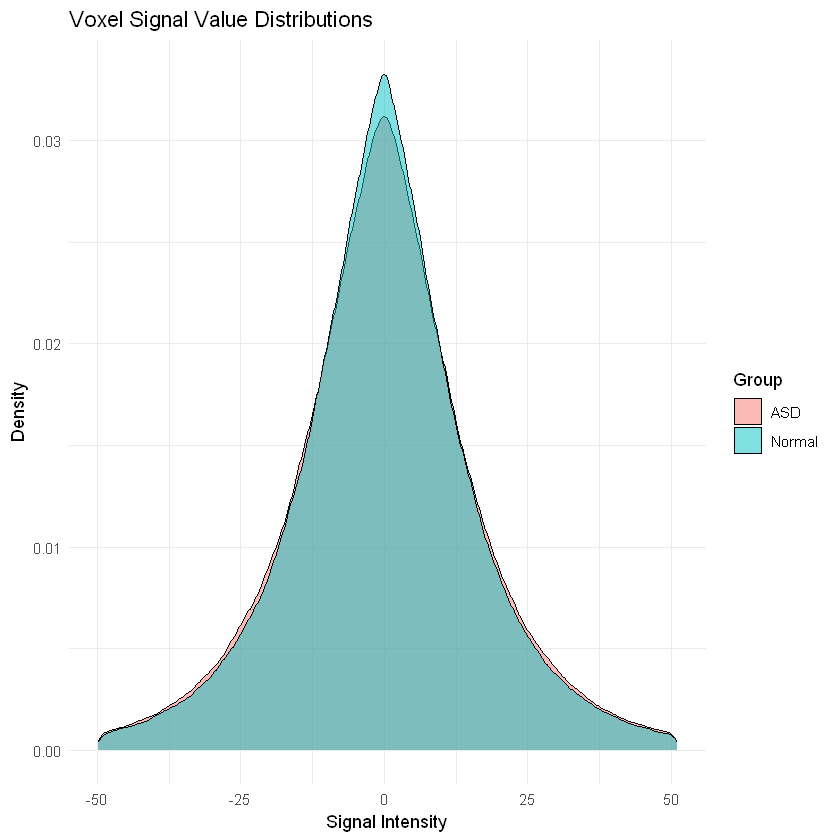

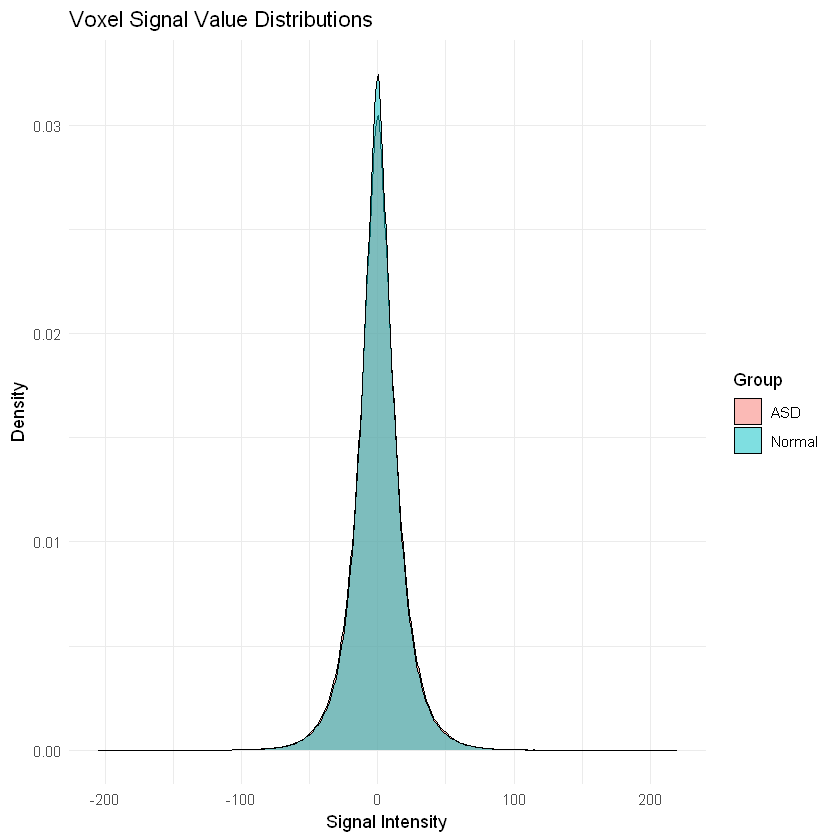

In [6]:
# File paths
asd_dir <- "data/Training Data/ASD"
normal_dir <- "data/Training Data/Normal"
label_file <- "data/Label of Brain Regions.csv"

# Load brain region labels
region_labels <- read.csv(label_file, header = TRUE, stringsAsFactors = FALSE)
colnames(region_labels) <- c("RegionCode", "RegionName")
region_labels$RegionCode <- as.character(region_labels$RegionCode)

# Load all subjects
asd_files <- list.files(asd_dir, full.names = TRUE, pattern = "*.csv")
normal_files <- list.files(normal_dir, full.names = TRUE, pattern = "*.csv")

asd_data_list <- lapply(asd_files, load_subject_data, region_labels = region_labels)
normal_data_list <- lapply(normal_files, load_subject_data, region_labels = region_labels)

names(asd_data_list) <- paste0("ASD_", seq_along(asd_data_list))
names(normal_data_list) <- paste0("Normal_", seq_along(normal_data_list))

# Prepare long-format data
asd_long <- reshape_subject_data(asd_data_list, "ASD")
normal_long <- reshape_subject_data(normal_data_list, "Normal")
all_data_long <- rbind(asd_long, normal_long)

# Plot voxel signal distributions
ggplot(all_data_long, aes(x = Signal, fill = Group)) +
  geom_density(alpha = 0.5) +
  scale_x_continuous(limits = quantile(all_data_long$Signal, c(0.01, 0.99), na.rm = TRUE)) +
  labs(title = "Voxel Signal Value Distributions", x = "Signal Intensity", y = "Density") +
  theme_minimal()

# No limit
ggplot(all_data_long, aes(x = Signal, fill = Group)) +
  geom_density(alpha = 0.5) +
  labs(title = "Voxel Signal Value Distributions", x = "Signal Intensity", y = "Density") +
  theme_minimal()

In [7]:
# Summary statistics (per region & group)
summary_all <- all_data_long %>%
  group_by(Group, RegionName) %>%
  summarise(
    Mean = mean(Signal, na.rm = TRUE),
    SD = sd(Signal, na.rm = TRUE),
    Min = min(Signal, na.rm = TRUE),
    Max = max(Signal, na.rm = TRUE),
    Median = median(Signal, na.rm = TRUE),
    .groups = "drop"
  )
summary_asd <- asd_long %>%
  group_by(Group, RegionName) %>%
  summarise(
    Mean = mean(Signal, na.rm = TRUE),
    SD = sd(Signal, na.rm = TRUE),
    Min = min(Signal, na.rm = TRUE),
    Max = max(Signal, na.rm = TRUE),
    Median = median(Signal, na.rm = TRUE),
    .groups = "drop"
  )
summary_normal <- normal_long %>%
  group_by(Group, RegionName) %>%
  summarise(
    Mean = mean(Signal, na.rm = TRUE),
    SD = sd(Signal, na.rm = TRUE),
    Min = min(Signal, na.rm = TRUE),
    Max = max(Signal, na.rm = TRUE),
    Median = median(Signal, na.rm = TRUE),
    .groups = "drop"
  )

print(head(summary_all, 20))
print(head(summary_asd, 20))
print(head(summary_normal, 20))

# A tibble: 20 × 7
   Group RegionName                             Mean    SD    Min   Max   Median
   <chr> <chr>                                 <dbl> <dbl>  <dbl> <dbl>    <dbl>
 1 ASD   Left Accumbens                     -0.00375 26.2  -117.  103.  -0.229  
 2 ASD   Left Amygdala                      -0.0312  22.3   -95.9 101.  -0.0982 
 3 ASD   Left Angular Gyrus                  0.0289  17.3   -79.6  76.1  0.0867 
 4 ASD   Left Caudate                        0.0140  10.9   -46.9  48.1 -0.0222 
 5 ASD   Left Central Opercular Cortex      -0.0402  17.0   -76.4  73.6 -0.324  
 6 ASD   Left Cingulate Gyrus; anterior di… -0.00368 11.4   -43.6  46.5 -0.00427
 7 ASD   Left Cingulate Gyrus; posterior d… -0.0284   9.05  -33.3  37.4  0.0624 
 8 ASD   Left Cuneal Cortex                 -0.00725 26.1  -116.  120.  -0.279  
 9 ASD   Left Frontal Medial Cortex          0.0265  20.7  -179.  220.  -0.0764 
10 ASD   Left Frontal Operculum Cortex       0.0302  22.5  -126.   94.9  0.112  
11 ASD   

In [8]:
summary(asd_long)
summary(normal_long)
summary(all_data_long)

      Time         RegionName            Signal             Subject         
 Min.   :  0.00   Length:968000      Min.   :-188.60820   Length:968000     
 1st Qu.: 43.75   Class :character   1st Qu.:  -9.80794   Class :character  
 Median : 87.50   Mode  :character   Median :  -0.08721   Mode  :character  
 Mean   : 87.50                      Mean   :  -0.01509                     
 3rd Qu.:131.25                      3rd Qu.:   9.64980                     
 Max.   :175.00                      Max.   : 219.86494                     
    Group          
 Length:968000     
 Class :character  
 Mode  :character  
                   
                   
                   

      Time         RegionName            Signal             Subject         
 Min.   :  0.00   Length:968000      Min.   :-205.23411   Length:968000     
 1st Qu.: 43.75   Class :character   1st Qu.:  -9.32470   Class :character  
 Median : 87.50   Mode  :character   Median :  -0.07622   Mode  :character  
 Mean   : 87.50                      Mean   :  -0.00527                     
 3rd Qu.:131.25                      3rd Qu.:   9.18868                     
 Max.   :175.00                      Max.   : 178.79883                     
    Group          
 Length:968000     
 Class :character  
 Mode  :character  
                   
                   
                   

      Time         RegionName            Signal             Subject         
 Min.   :  0.00   Length:1936000     Min.   :-205.23411   Length:1936000    
 1st Qu.: 43.75   Class :character   1st Qu.:  -9.56426   Class :character  
 Median : 87.50   Mode  :character   Median :  -0.08125   Mode  :character  
 Mean   : 87.50                      Mean   :  -0.01018                     
 3rd Qu.:131.25                      3rd Qu.:   9.40980                     
 Max.   :175.00                      Max.   : 219.86494                     
    Group          
 Length:1936000    
 Class :character  
 Mode  :character  
                   
                   
                   

In [9]:
#Shows the Region names as a table
print(unique(asd_long$RegionName))
print(length(unique(asd_long$RegionName)))

  [1] "Left Thalamus"                                                            
  [2] "Left Caudate"                                                             
  [3] "Left Putamen"                                                             
  [4] "Left Pallidum"                                                            
  [5] "Left Hippocampus"                                                         
  [6] "Left Amygdala"                                                            
  [7] "Left Accumbens"                                                           
  [8] "Right Thalamus"                                                           
  [9] "Right Caudate"                                                            
 [10] "Right Putamen"                                                            
 [11] "Right Pallidum"                                                           
 [12] "Right Hippocampus"                                                        
 [13] "Right Amy

[1] 110


In [10]:
# Access example subjects
ASD_26 <- asd_data_list[["ASD_26"]]
Normal_37 <- normal_data_list[["Normal_37"]]
head(ASD_26)

,Time,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Left Hippocampus,Left Amygdala,Left Accumbens,Right Thalamus,Right Caudate,⋯,Right Planum Polare,Left Planum Polare,Right Heschl's Gyrus (includes H1 and H2),Left Heschl's Gyrus (includes H1 and H2),Right Planum Temporale,Left Planum Temporale,Right Supracalcarine Cortex,Left Supracalcarine Cortex,Right Occipital Pole,Left Occipital Pole
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,-6.743464,-0.914306,-14.62304,5.851551,7.992399,-18.68383,0.754312,-0.449771,-5.839773,⋯,-35.185715,-2.928083,0.425990,-17.795643,11.121651,-13.465437,-9.292003,-30.34968,-5.20509,-1.652152
2,1,-9.347871,-0.577119,-16.10221,10.367333,11.047755,-12.24571,6.855634,-3.452420,3.716789,⋯,-44.960901,-6.512893,-6.135171,-13.144289,9.087565,-4.639542,-10.312183,-46.02102,-30.55020,-20.270377
3,2,-3.668645,2.301078,-3.74550,13.435687,13.531475,14.94994,13.691762,6.801156,18.599672,⋯,-31.354104,3.472175,-2.814472,8.402168,6.408381,12.995796,-22.929029,-41.91286,-51.33673,-34.462431
4,3,6.449822,7.489157,13.53070,11.438150,13.700101,41.16186,14.327866,28.644760,29.186706,⋯,-1.365856,17.191443,7.977556,24.809976,0.766056,18.926489,-45.386448,-27.21586,-55.41472,-35.477509
5,4,12.924217,10.366625,23.03502,4.775410,9.130782,40.74686,7.540922,40.804726,26.224571,⋯,26.126584,20.370979,18.938860,22.541270,-4.428515,6.535273,-58.984608,-17.20228,-44.08510,-27.003535
6,5,11.739305,6.348260,20.33079,-1.080258,0.284814,12.79124,-0.724109,23.153163,9.025535,⋯,35.147675,11.312914,25.832348,12.361558,-1.526549,-7.248989,-44.858669,-11.87269,-27.14810,-18.410412


In [11]:
summary(Normal_37)
summary(Normal_37$`Left Thalamus`)

      Time        Left Thalamus       Left Caudate       Left Putamen     
 Min.   :  0.00   Min.   :-25.2758   Min.   :-21.5982   Min.   :-30.5877  
 1st Qu.: 43.75   1st Qu.: -6.8027   1st Qu.: -7.0897   1st Qu.: -7.0099  
 Median : 87.50   Median :  0.5428   Median : -0.3149   Median : -0.7683  
 Mean   : 87.50   Mean   : -0.4841   Mean   : -0.2952   Mean   : -0.1289  
 3rd Qu.:131.25   3rd Qu.:  5.9876   3rd Qu.:  5.6893   3rd Qu.:  6.1776  
 Max.   :175.00   Max.   : 25.9721   Max.   : 22.6385   Max.   : 27.6136  
 Left Pallidum       Left Hippocampus   Left Amygdala      Left Accumbens   
 Min.   :-36.59770   Min.   :-27.0563   Min.   :-73.4715   Min.   :-62.501  
 1st Qu.:-10.36552   1st Qu.: -6.0799   1st Qu.:-17.6658   1st Qu.:-19.910  
 Median : -0.26642   Median :  0.4463   Median : -1.4727   Median : -1.854  
 Mean   : -0.07547   Mean   : -0.1085   Mean   :  0.2712   Mean   : -0.852  
 3rd Qu.:  8.34983   3rd Qu.:  7.2653   3rd Qu.: 21.0390   3rd Qu.: 18.967  
 Max.   : 38.

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-25.2758  -6.8027   0.5428  -0.4841   5.9876  25.9721 

In [12]:
length(Normal_37$`Left Thalamus`)

[1] 176

### MDD T500 data

In [31]:
load_subject_data_noheader <- function(file_path, region_labels) {
  df <- read.table(file_path, header = FALSE, stringsAsFactors = FALSE)
  colnames(df) <- paste0("Region", seq_len(ncol(df)))  # Assign dummy region codes
  df$Time <- 0:(nrow(df) - 1)
  df <- df[, c("Time", paste0("Region", seq_len(ncol(df) - 1)))]  # Ensure 'Time' is first
  return(df)
}
hcs_ids <- readLines("mddT500/hcs.txt")
mdd_ids <- readLines("mddT500/mdd.txt")
# For HCS
hcs_data_list <- lapply(hcs_ids, function(id) {
  file_path <- file.path("mddT500", "timeseries", paste0(id, ".txt"))
  load_subject_data_noheader(file_path, NULL)
})
names(hcs_data_list) <- paste0("HCS_", seq_along(hcs_data_list))

# For MDD
mdd_data_list <- lapply(mdd_ids, function(id) {
  file_path <- file.path("mddT500", "timeseries", paste0(id, ".txt"))
  load_subject_data_noheader(file_path, NULL)
})
names(mdd_data_list) <- paste0("MDD_", seq_along(mdd_data_list))
# Use existing reshape function
hcs_long <- reshape_subject_data(hcs_data_list, "HCS")
mdd_long <- reshape_subject_data(mdd_data_list, "MDD")

# Combine all
all_hdd_data_long <- rbind(hcs_long, mdd_long)
summary(all_hdd_data_long)

      Time         RegionName            Signal           Subject         
 Min.   :  0.00   Length:5310000     Min.   :-75.8463   Length:5310000    
 1st Qu.: 58.75   Class :character   1st Qu.: -0.4777   Class :character  
 Median :117.50   Mode  :character   Median :  0.0000   Mode  :character  
 Mean   :117.50                      Mean   :  0.0000                     
 3rd Qu.:176.25                      3rd Qu.:  0.4745                     
 Max.   :235.00                      Max.   : 25.1632                     
    Group          
 Length:5310000    
 Class :character  
 Mode  :character  
                   
                   
                   

In [34]:
# list of regions in hcs and mdd
hcs_regions <- unique(hcs_long$RegionName)
hcs_regions

[1] "Region1"  "Region2"  "Region3"  "Region4"  "Region5"  "Region6" 
 [7] "Region7"  "Region8"  "Region9"  "Region10" "Region11" "Region12"
[13] "Region13" "Region14" "Region15" "Region16" "Region17" "Region18"
[19] "Region19" "Region20" "Region21" "Region22" "Region23" "Region24"
[25] "Region25" "Region26" "Region27" "Region28" "Region29" "Region30"
[31] "Region31" "Region32" "Region33" "Region34" "Region35" "Region36"
[37] "Region37" "Region38" "Region39" "Region40" "Region41" "Region42"
[43] "Region43" "Region44" "Region45" "Region46" "Region47" "Region48"
[49] "Region49" "Region50" "Region51" "Region52" "Region53" "Region54"
[55] "Region55" "Region56" "Region57" "Region58" "Region59" "Region60"
[61] "Region61" "Region62" "Region63" "Region64" "Region65" "Region66"
[67] "Region67" "Region68" "Region69" "Region70" "Region71" "Region72"
[73] "Region73" "Region74" "Region75" "Region76" "Region77" "Region78"
[79] "Region79" "Region80" "Region81" "Region82" "Region83" "Region84"
[85] "Region85" "Region86" "Region87" "Region88" "Region89" "Region90"

In [44]:
# list of regions in hcs and mdd
hcs_names <- unique(hcs_long$Subject)
hcs_names

[1] "HCS_1"  "HCS_2"  "HCS_3"  "HCS_4"  "HCS_5"  "HCS_6"  "HCS_7"  "HCS_8" 
 [9] "HCS_9"  "HCS_10" "HCS_11" "HCS_12" "HCS_13" "HCS_14" "HCS_15" "HCS_16"
[17] "HCS_17" "HCS_18" "HCS_19" "HCS_20" "HCS_21" "HCS_22" "HCS_23" "HCS_24"
[25] "HCS_25" "HCS_26" "HCS_27" "HCS_28" "HCS_29" "HCS_30" "HCS_31" "HCS_32"
[33] "HCS_33" "HCS_34" "HCS_35" "HCS_36" "HCS_37" "HCS_38" "HCS_39" "HCS_40"
[41] "HCS_41" "HCS_42" "HCS_43" "HCS_44" "HCS_45" "HCS_46" "HCS_47" "HCS_48"
[49] "HCS_49" "HCS_50" "HCS_51" "HCS_52" "HCS_53" "HCS_54" "HCS_55"

In [40]:
summary(hcs_long)

      Time         RegionName            Signal           Subject         
 Min.   :  0.00   Length:1168200     Min.   :-10.3786   Length:1168200    
 1st Qu.: 58.75   Class :character   1st Qu.: -0.4816   Class :character  
 Median :117.50   Mode  :character   Median :  0.0000   Mode  :character  
 Mean   :117.50                      Mean   :  0.0000                     
 3rd Qu.:176.25                      3rd Qu.:  0.4800                     
 Max.   :235.00                      Max.   :  7.4841                     
    Group          
 Length:1168200    
 Class :character  
 Mode  :character  
                   
                   
                   

In [49]:
s1 <- hcs_data_list[['HCS_12']]
head(s1$Region1)
head(s1$Region40)

[1]  0.6016208  0.5448442  1.7282218 -2.3808618 -0.5599782  0.2605891

[1]  0.32557764 -0.01733699  1.34778714 -2.09290990 -0.20704240  1.57272268

## Preprocessing

### Smoothing

In [13]:
smoothed_ASD_26 <- smooth_subject_data(ASD_26, bandwidth = 2)
summary(smoothed_ASD_26$`Right Thalamus`)
summary(ASD_26$`Right Thalamus`)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-73.9986 -13.7151   0.3822   0.1592  16.9165  61.9932 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-84.0837 -15.3045   0.8322   0.1689  19.1084  75.4142 

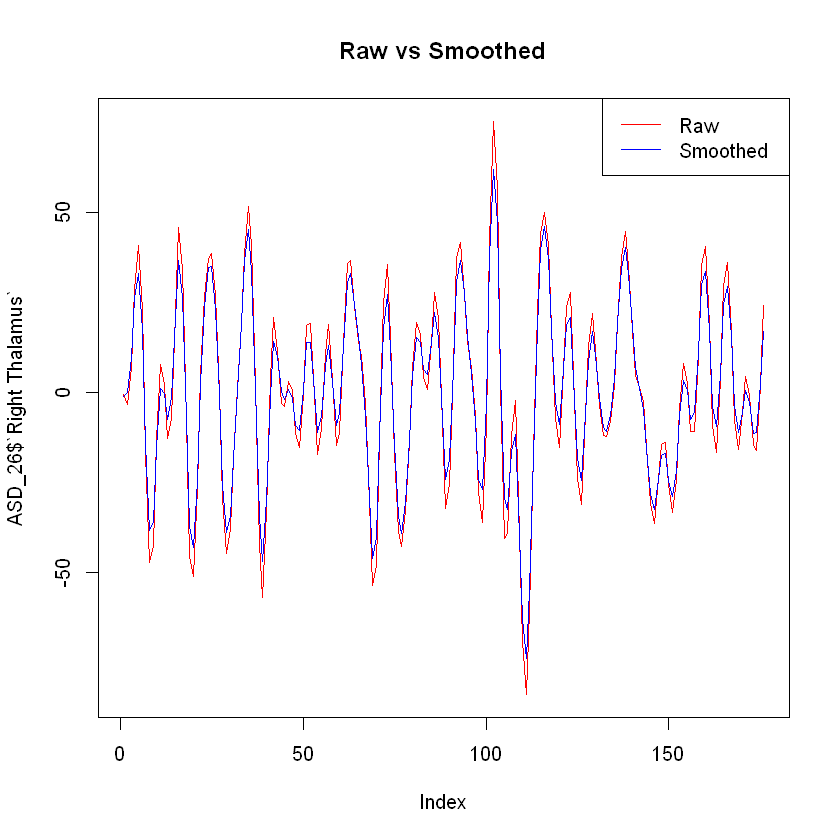

In [14]:
plot(ASD_26$`Right Thalamus`, type = "l", col = "red", main = "Raw vs Smoothed")
lines(smoothed_ASD_26$`Right Thalamus`, col = "blue")
legend("topright", legend = c("Raw", "Smoothed"), col = c("red", "blue"), lty = 1)


In [15]:
smoothed_asd_long <- smooth_all_subjects_to_long(asd_data_list, "ASD", bandwidth = 2)
smoothed_normal_long <- smooth_all_subjects_to_long(normal_data_list, "Normal", bandwidth = 2)

# Combine into one long smoothed dataset
smoothed_all_data_long <- bind_rows(smoothed_asd_long, smoothed_normal_long)

In [16]:
# ASD 26 from smoothed_asd_long
asd_26_smoothed <- smoothed_asd_long %>% filter(Subject == "ASD_26")
# summary of 'Right Thalamus' region
asd_26_smoothed_thalamus <- asd_26_smoothed %>% filter(RegionName == "Right Thalamus")
summary(asd_26_smoothed_thalamus$SmoothedSignal)
#smoothed_ASD_26 <- smooth_subject_data(ASD_26, bandwidth = 2)
summary(smoothed_ASD_26$`Right Thalamus`)
summary(ASD_26$`Right Thalamus`)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-73.9986 -13.7151   0.3822   0.1592  16.9165  61.9932 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-73.9986 -13.7151   0.3822   0.1592  16.9165  61.9932 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-84.0837 -15.3045   0.8322   0.1689  19.1084  75.4142 

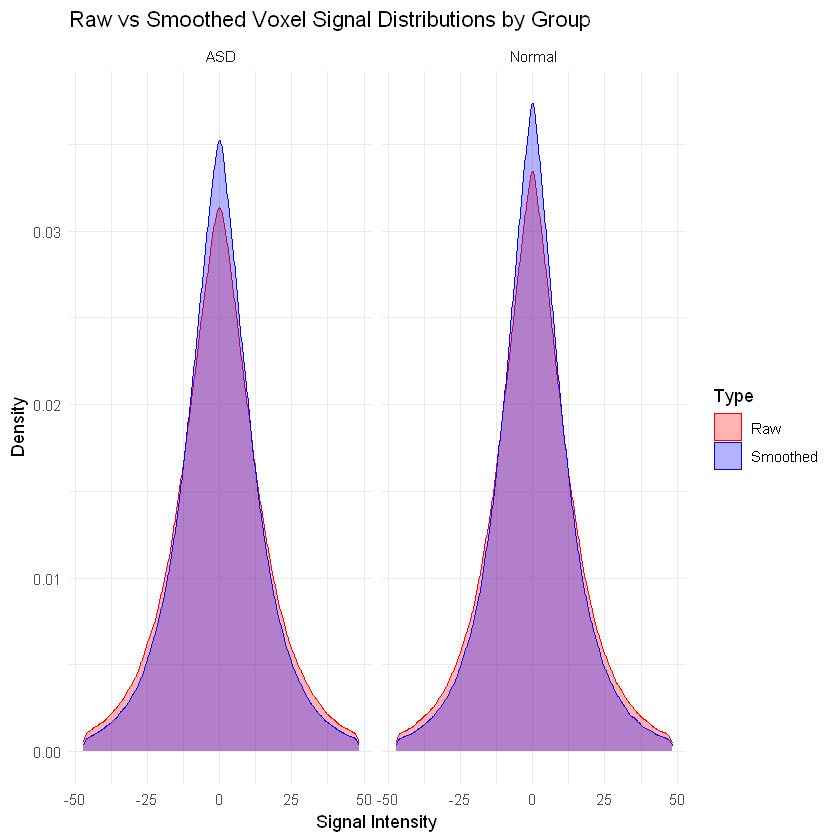

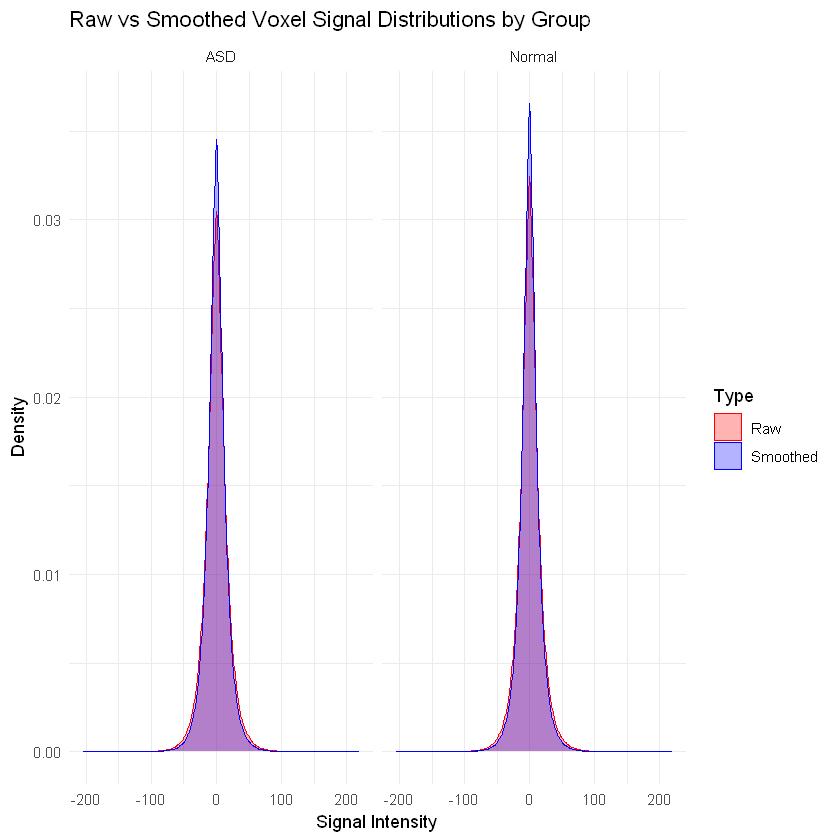

In [17]:
# Prepare data for comparison
raw_density <- all_data_long %>%
  select(Group, Signal) %>%
  mutate(Type = "Raw")

smoothed_density <- smoothed_all_data_long %>%
  select(Group, SmoothedSignal) %>%
  rename(Signal = SmoothedSignal) %>%
  mutate(Type = "Smoothed")

# Combine raw and smoothed
combined_density_data <- bind_rows(raw_density, smoothed_density)

# Plot both on the same density plot
ggplot(combined_density_data, aes(x = Signal, fill = Type, color = Type)) +
  geom_density(alpha = 0.3) +
  facet_wrap(~ Group) +
  labs(
    title = "Raw vs Smoothed Voxel Signal Distributions by Group",
    x = "Signal Intensity",
    y = "Density"
  ) +
  theme_minimal() +
  scale_fill_manual(values = c("Raw" = "red", "Smoothed" = "blue")) +
  scale_color_manual(values = c("Raw" = "red", "Smoothed" = "blue")) +
  scale_x_continuous(limits = quantile(combined_density_data$Signal, c(0.01, 0.99), na.rm = TRUE))

ggplot(combined_density_data, aes(x = Signal, fill = Type, color = Type)) +
  geom_density(alpha = 0.3) +
  facet_wrap(~ Group) +
  labs(
    title = "Raw vs Smoothed Voxel Signal Distributions by Group",
    x = "Signal Intensity",
    y = "Density"
  ) +
  theme_minimal() +
  scale_fill_manual(values = c("Raw" = "red", "Smoothed" = "blue")) +
  scale_color_manual(values = c("Raw" = "red", "Smoothed" = "blue"))


### Normalization (Scaling)

In [18]:
all_data_long %>%
  group_by(Subject, RegionName) %>%
  summarise(
    SD = sd(Signal, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  filter(SD == 0 | is.na(SD))


Subject,RegionName,SD
<chr>,<chr>,<dbl>
Normal_25,Right Temporal Fusiform Cortex; anterior division,0


      Time         RegionName            Signal             Subject         
 Min.   :  0.00   Length:1936000     Min.   :-205.23411   Length:1936000    
 1st Qu.: 43.75   Class :character   1st Qu.:  -9.56426   Class :character  
 Median : 87.50   Mode  :character   Median :  -0.08125   Mode  :character  
 Mean   : 87.50                      Mean   :  -0.01018                     
 3rd Qu.:131.25                      3rd Qu.:   9.40980                     
 Max.   :175.00                      Max.   : 219.86494                     
    Group              Signal_Z        
 Length:1936000     Min.   :-4.904639  
 Class :character   1st Qu.:-0.671048  
 Mode  :character   Median :-0.006079  
                    Mean   : 0.000000  
                    3rd Qu.: 0.663475  
                    Max.   : 6.536272  

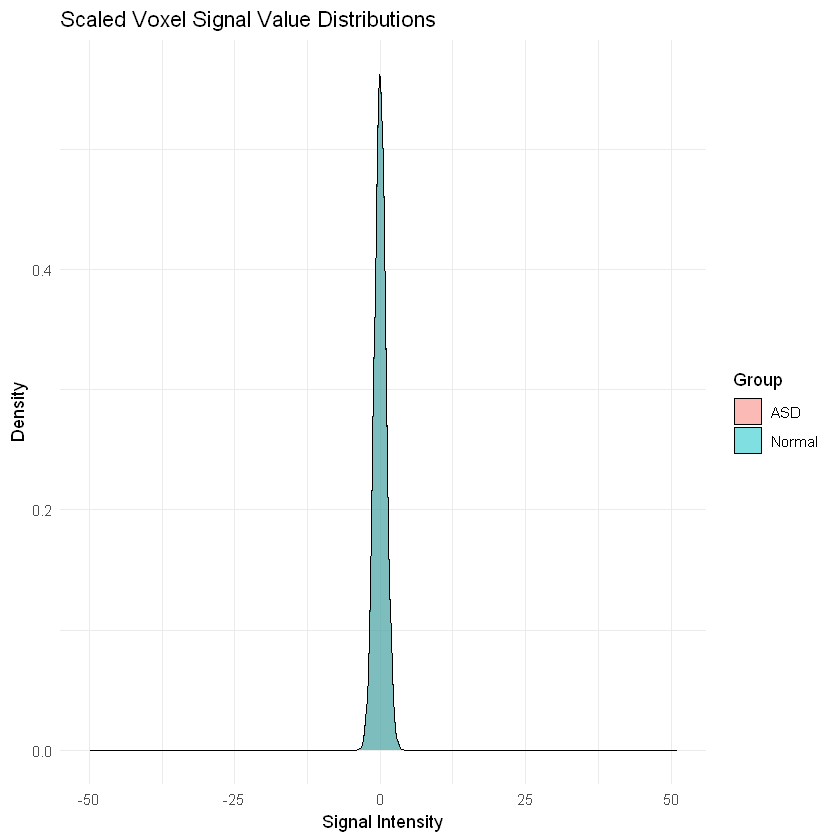

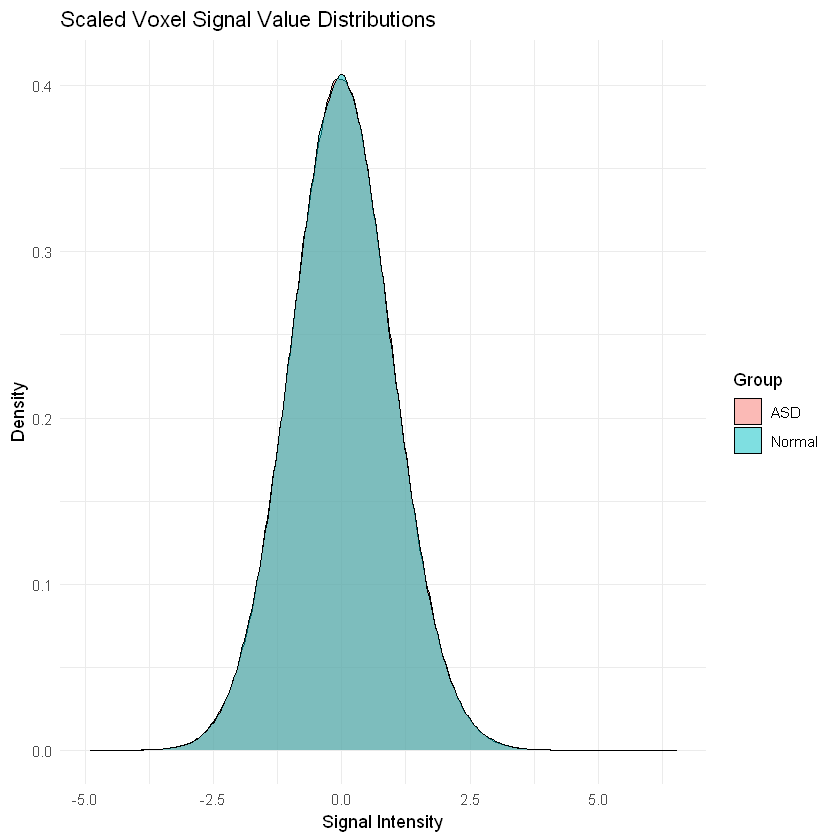

In [19]:
normalized_all_data_long <- all_data_long %>%
  group_by(Subject, RegionName) %>%
  mutate(
    Signal_Z = if (sd(Signal, na.rm = TRUE) > 0) as.numeric(scale(Signal)) else 0
  ) %>%
  ungroup()


summary(normalized_all_data_long)

# Plot voxel signal distributions
ggplot(normalized_all_data_long, aes(x = Signal_Z, fill = Group)) +
  geom_density(alpha = 0.5) +
  scale_x_continuous(limits = quantile(normalized_all_data_long$Signal, c(0.01, 0.99), na.rm = TRUE)) +
  labs(title = "Scaled Voxel Signal Value Distributions", x = "Signal Intensity", y = "Density") +
  theme_minimal()

# No limit
ggplot(normalized_all_data_long, aes(x = Signal_Z, fill = Group)) +
  geom_density(alpha = 0.5) +
  labs(title = "Scaled Voxel Signal Value Distributions", x = "Signal Intensity", y = "Density") +
  theme_minimal()

### Feature Extraction

In [20]:
# Summary statistics (per region & group)
summary_stats <- all_data_long %>%
  group_by(Subject, Group, RegionName) %>%
  summarise(
    Mean = mean(Signal, na.rm = TRUE),
    SD = sd(Signal, na.rm = TRUE),
    Min = min(Signal, na.rm = TRUE),
    Max = max(Signal, na.rm = TRUE),
    Median = median(Signal, na.rm = TRUE),
    .groups = "drop"
  )

print(head(summary_stats, 20))


# A tibble: 20 × 8
   Subject Group RegionName                       Mean    SD    Min   Max Median
   <chr>   <chr> <chr>                           <dbl> <dbl>  <dbl> <dbl>  <dbl>
 1 ASD_1   ASD   Left Accumbens                -0.563  32.6   -90.8  83.9  1.37 
 2 ASD_1   ASD   Left Amygdala                 -0.223  33.0   -78.6  84.3 -2.68 
 3 ASD_1   ASD   Left Angular Gyrus             0.0661 20.4   -66.9  46.4 -0.683
 4 ASD_1   ASD   Left Caudate                   0.0945 11.0   -30.8  33.0  0.749
 5 ASD_1   ASD   Left Central Opercular Cortex  0.0670 18.3   -46.6  39.6  0.522
 6 ASD_1   ASD   Left Cingulate Gyrus; anteri…  0.0903 15.7   -32.8  46.5  0.583
 7 ASD_1   ASD   Left Cingulate Gyrus; poster…  0.0295 10.2   -30.1  25.7  0.705
 8 ASD_1   ASD   Left Cuneal Cortex            -0.570  33.6   -74.3 103.  -0.306
 9 ASD_1   ASD   Left Frontal Medial Cortex    -0.0506 44.4  -179.  172.   3.40 
10 ASD_1   ASD   Left Frontal Operculum Cortex  0.208  25.3   -71.1  61.9  1.38 
11 ASD_1 

In [21]:
# Spread region-wise stats (e.g., mean signal) into wide format
features_wide <- summary_stats %>%
  select(Subject, Group, RegionName, Mean) %>%
  tidyr::pivot_wider(names_from = RegionName, values_from = Mean)

# Remove subjects with any NA
features_wide <- na.omit(features_wide)

# Convert Group to factor
features_wide$Group <- as.factor(features_wide$Group)

# Create dataset
set.seed(123)  # For reproducibility

# Assume 'features_wide' is your dataset and has a column called 'Group'
train_ratio <- 0.8
group_labels <- features_wide$Group

# Create stratified sample index manually
train_idx <- unlist(lapply(split(seq_along(group_labels), group_labels), function(idx) {
  sample(idx, floor(length(idx) * train_ratio))
}))

# Now use these indices to split the data
train_data <- features_wide[train_idx, ]
test_data <- features_wide[-train_idx, ]

# Fix column names
colnames(train_data) <- make.names(colnames(train_data))
colnames(test_data) <- make.names(colnames(test_data))

## Machine Learning Methods

### Random Forest

In [22]:
rf_model <- randomForest(Group ~ ., data = train_data[, -1], importance = TRUE, ntree = 500)
rf_preds <- predict(rf_model, test_data)

# Confusion matrix using base R
conf_mat <- table(Predicted = rf_preds, Actual = test_data$Group)
print(conf_mat)

# Accuracy
accuracy <- sum(diag(conf_mat)) / sum(conf_mat)
cat("Accuracy:", round(accuracy * 100, 2), "%\n")


         Actual
Predicted ASD Normal
   ASD      6      7
   Normal   4      3
Accuracy: 45 %


### XGBoost

In [23]:
# Convert to numeric matrix and label vector
train_matrix <- as.matrix(train_data[, -c(1,2)])
test_matrix <- as.matrix(test_data[, -c(1,2)])
train_label <- ifelse(train_data$Group == "ASD", 1, 0)
test_label <- ifelse(test_data$Group == "ASD", 1, 0)

# XGBoost model
xgb_model <- xgboost(
  data = train_matrix,
  label = train_label,
  nrounds = 100,
  objective = "binary:logistic",
  eval_metric = "error",
  verbose = 0
)

# Predictions
xgb_preds <- predict(xgb_model, test_matrix)
xgb_class <- ifelse(xgb_preds > 0.5, "ASD", "Normal")

# Confusion matrix for XGBoost
conf_mat_xgb <- table(Predicted = xgb_class, Actual = test_data$Group)
print(conf_mat_xgb)
# Accuracy for XGBoost
accuracy_xgb <- sum(diag(conf_mat_xgb)) / sum(conf_mat_xgb)
cat("XGBoost Accuracy:", round(accuracy_xgb * 100, 2), "%\n")

         Actual
Predicted ASD Normal
   ASD      6      6
   Normal   4      4
XGBoost Accuracy: 50 %


In [24]:
### voxel pair
# transpose data to make timeseries columns
# scale will mean center and sd scale each column
two_voxels <- scale(t(read.table("voxel_A&B_data.txt", header=T)))
num_time <- dim(two_voxels)[1]
plot(1:num_time,two_voxels[,1],type="l",xlab="time", ylab="BOLD", main="First Voxel")

# plot BOLD signals
library(ggplot2)
library(reshape2)
voxels.df <- data.frame(time=1:num_time, Voxel1=two_voxels[,1], Voxel2=two_voxels[,2])
melt.df <- melt(data = voxels.df, measure.vars = c("Voxel1", "Voxel2"))
ggplot(melt.df, aes(x=time, y=value, group=variable)) +
  geom_line(aes(linetype=variable)) +
  geom_point(aes(shape=variable, color=variable), size=2) +
  scale_color_manual(values = c("#FC4E07", "#E7B800")) +
  xlab("Time") +
  ylab("BOLD") +
  ggtitle("Two Voxels") + 
  theme(plot.title = element_text(hjust = 0.5)) + theme_bw() 

# pair comparison
plot(two_voxels[,1],two_voxels[,2],xlab="Voxel 1", ylab="Voxel 2", main="Comparison")
abline(lm(two_voxels[,2]~two_voxels[,1]))
cor(two_voxels)

#library(dplyr)
# autoregressive data set
# create a data frame with all the required lagged columns,
#as well as the response variable. 
xdata = voxels.df[,2:3]
# using voxel 2 to help predict voxel 1 doesn't seem to help
#arframe <- data.frame(vox1_predict = xdata[, "Voxel1"],
#                        V1.L1 = lag(xdata$Voxel1 , 1), 
#                        V1.L2 = lag(xdata$Voxel1 , 2),
#                        V2.L1 = lag(xdata$Voxel2 , 1), 
#                        V2.L2 = lag(xdata$Voxel2 , 2)
#                        )
# predict voxel 1 using lagged voxel 1 values
arframe <- data.frame(vox1_predict = xdata[, "Voxel1"],
                      V1.L1 = lag(xdata$Voxel1 , 1), 
                      V1.L2 = lag(xdata$Voxel1 , 2)
                      #V1.L3 = lag(xdata$Voxel1 , 3) 
                      #V1.L4 = lag(xdata$Voxel1 , 4)
                      )
# remove NA's at end points where lag cannot be computed
arframe <- na.omit(arframe)
# Fit the model
train = 1:round((nrow(arframe)/2)) # train first half
test = which(1:nrow(arframe)!=train) # the rest
lmfit = lm(vox1_predict ~ ., data = arframe[train,])
lmpred = predict(lmfit , arframe[test , ])
plot(lmpred,arframe[test , "vox1_predict"],xlab="Predicted", ylab="Observed", main="Voxel 1 linear regression")
abline(lm(arframe[test , "vox1_predict"] ~ lmpred))
abline(a=0,b=1, col="red")
lm(arframe[test , "vox1_predict"] ~ lmpred)
coefficients(lmfit)
#sqrt(sum(lmfit$residuals^2))/length(lmfit$residuals)
# mean sum of squared test error
sum(sqrt((lmpred - arframe[test , "vox1_predict"])^2))/length(lmpred) 
#V0 = var(arframe[train, "vox1_predict"])
# error
#1-mean((lmpred - arframe[test , "vox1_predict"])^2) / V0

# Random Forest does not seem to work better than linear regression
library(ranger)
ar_rf_fit = ranger(vox1_predict ~ ., arframe[train,], 
                               keep.inbag = TRUE,
                               importance="permutation", 
                               scale.permutation.importance = T,
                               local.importance = T,
                   num.trees=5000)
sort(ar_rf_fit$variable.importance,decreasing=T)
ar_rf_fit$prediction.error # training
rf_pred = predict(ar_rf_fit, 
                  data = arframe[test,] %>% select(-vox1_predict), 
                  type = "response")
rf_se = predict(ar_rf_fit, 
                  data = arframe[test,] %>% select(-vox1_predict), 
                  type = "se")
#sqrt(sum(rf_se$se))/length(rf_se$se) # ave error
# mean sum of squared test error
sqrt(sum((rf_pred$predictions - arframe[test , "vox1_predict"])^2))/length(rf_pred) 
plot(rf_pred$predictions,arframe[test , "vox1_predict"],xlab="Predicted", ylab="Observed", main="Voxel 1 RF")
abline(a=0,b=1, col="red")
abline(lm(arframe[test , "vox1_predict"] ~ rf_pred$predictions))

ERROR: Error in file(file, "rt"): cannot open the connection


### tsfeatures Feature Extraction

In [53]:
# Suppress plotting globally during feature extraction
old_par <- par(no.readonly = TRUE)  # Save current graphical parameters
pdf(NULL)  # Redirect plots to NULL

# Your feature extraction code
asd_features <- bind_rows(lapply(seq_along(asd_data_list), function(i) {
  extract_tsfeatures_subject(asd_data_list[[i]], paste0("ASD_", i), "ASD")
}))
normal_features <- bind_rows(lapply(seq_along(normal_data_list), function(i) {
  extract_tsfeatures_subject(normal_data_list[[i]], paste0("Normal_", i), "Normal")
}))

# Restore plotting
dev.off()
par(old_par)

# Combine all
features_df <- bind_rows(asd_features, normal_features)

png 
  2

In [26]:
head(features_df)
summary(features_df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V104,V105,V106,V107,V108,V109,V110,Region,Subject,Group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
mean...1,-3.16759521075026e-18,-4.46062950623156e-18,-2.94034108368914e-17,2.97465650596478e-17,1.26238710338973e-17,2.07285902852072e-17,-1.97534243539319e-17,-1.61644687534202e-17,7.34054152689618e-18,-2.50136529623715e-17,⋯,1.87636278535677e-17,4.49589687803542e-18,-2.11671993458946e-17,1.06732311593658e-17,8.92372310830967e-18,1.16169798685975e-17,1.11500337056748e-18,mean,ASD_1,ASD
var...2,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,var,ASD_1,ASD
acf1...3,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,acf1,ASD_1,ASD
acf2...4,0.737699835009927,0.746596549022538,0.735110129387169,0.726845830610883,0.763021767549526,0.758600623816781,0.771891650302713,0.762828692422835,0.760238693103357,0.740610717761812,⋯,0.782293847388092,0.816651954586897,0.834511456094549,0.797994072821478,0.764877187916555,0.725464014804126,0.751608941528756,acf2,ASD_1,ASD
acf3...5,0.147941329948588,0.195817871889677,0.144394048071197,0.15459831911211,0.238328255849133,0.233020599657333,0.265196482350024,0.243412603798623,0.221325374582648,0.159094315327266,⋯,0.305753776835982,0.388590804678297,0.444311906811139,0.33778780051319,0.25266334818585,0.128989295060203,0.201963926856469,acf3,ASD_1,ASD
acf4...6,-0.354420066729769,-0.237920162256195,-0.353742259709257,-0.299892615776587,-0.19688067396518,-0.178107272364465,-0.162065120963438,-0.203328082825952,-0.249666410501569,-0.35373118733336,⋯,-0.0942069244207966,-0.0265629475849441,0.0566327438021669,-0.0858629538882537,-0.155872344476207,-0.345111143275163,-0.25733702102334,acf4,ASD_1,ASD


      V1                 V2                 V3                 V4           
 Length:5200        Length:5200        Length:5200        Length:5200       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
      V5                 V6                 V7                 V8           
 Length:5200        Length:5200        Length:5200        Length:5200       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
      V9                V10                V11                V12           
 Length:5200        Length:5200        Length:5200        Length:5200       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
     V13                V14                V15                V16           

### Random Forest with tsfeatures

In [139]:
# Convert Group to factor
features_df$Group <- as.factor(features_df$Group)

# Train/test split
set.seed(123)
n <- nrow(features_df)
train_idx <- sample(seq_len(n), size = 0.8 * n)
train_data <- features_df[train_idx, ]
test_data <- features_df[-train_idx, ]

# Remove rows with NAs from both training and testing sets
train_data <- na.omit(train_data)
test_data <- na.omit(test_data)

# Fit Random Forest (remove "Subject" and optionally "Region")
rf_model <- randomForest(Group ~ ., 
                         data = train_data[, !(names(train_data) %in% c("Subject", "Region"))], 
                         importance = TRUE, 
                         ntree = 500)

# Predict
rf_preds <- predict(rf_model, test_data)

# Confusion Matrix and Accuracy
conf_mat <- table(Predicted = rf_preds, Actual = test_data$Group)
print(conf_mat)

accuracy <- sum(diag(conf_mat)) / sum(conf_mat)
cat("Accuracy:", round(accuracy * 100, 2), "%\n")



         Actual
Predicted ASD Normal
   ASD    106     90
   Normal 408    422
Accuracy: 51.46 %


### XGBoost with tsfeatures

In [28]:
# Drop non-feature columns
feature_cols <- !(names(features_df) %in% c("Subject", "Group", "Region"))
features_clean <- features_df[, feature_cols]

# Convert everything to numeric (this will coerce characters, logicals etc.)
features_clean[] <- lapply(features_clean, function(x) as.numeric(as.character(x)))

# Handle remaining NAs (optional: here we replace NAs with 0, or use imputation)
features_clean[is.na(features_clean)] <- 0

# Convert to matrix
train_matrix <- as.matrix(features_clean[train_idx, ])
test_matrix  <- as.matrix(features_clean[-train_idx, ])

# Labels
train_label <- as.numeric(features_df$Group[train_idx]) - 1  # xgboost needs 0/1
test_label  <- as.numeric(features_df$Group[-train_idx]) - 1

dtrain <- xgb.DMatrix(data = train_matrix, label = train_label)
dtest  <- xgb.DMatrix(data = test_matrix, label = test_label)

params <- list(
  objective = "binary:logistic",
  eval_metric = "error",
  max_depth = 6,
  eta = 0.1
)

xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 100,
  watchlist = list(train = dtrain, eval = dtest),
  verbose = 0
)

# Predictions
pred_probs <- predict(xgb_model, dtest)
pred_labels <- ifelse(pred_probs > 0.5, 1, 0)

# Confusion matrix & accuracy
conf_mat <- table(Predicted = pred_labels, Actual = test_label)
print(conf_mat)
accuracy <- sum(diag(conf_mat)) / sum(conf_mat)
cat("Accuracy:", round(accuracy * 100, 2), "%\n")

         Actual
Predicted   0   1
        0 422 343
        1  92 183
Accuracy: 58.17 %


### PCA

In [ ]:
# rename columns for clarity
features_clean <- features_df %>%
  rename(Feature = Region)

# Pivot longer to standardize the structure
features_long <- features_clean %>%
  pivot_longer(cols = -c(Feature, Subject, Group),
               names_to = "Region", values_to = "Value")

# Now pivot wider to make each row a subject, and each column a Region-Feature combo
features_wide <- features_long %>%
  mutate(RegionFeature = paste0(Region, "_", Feature)) %>%
  select(Subject, Group, RegionFeature, Value) %>%
  pivot_wider(names_from = RegionFeature, values_from = Value)

# Convert Group to factor
features_wide$Group <- as.factor(features_wide$Group)

# remove rows with any NA
features_wide <- features_wide %>% drop_na()
# Extract features and ensure numeric conversion
feature_matrix <- features_wide %>%
  select(-Subject, -Group) %>%
  mutate(across(everything(), ~as.numeric(.)))

In [ ]:
# identify columns with non-zero and non-NA variance
non_constant_columns <- sapply(feature_matrix, function(x) {
  v <- var(x, na.rm = TRUE)
  !is.na(v) && v > 0
})

# Subset to retain only non-constant columns
feature_matrix_clean <- feature_matrix[, non_constant_columns]

# Run PCA on cleaned data
pca_result <- prcomp(feature_matrix_clean, scale. = TRUE)
summary(pca_result)

# top components
pc_data <- as.data.frame(pca_result$x[, 1:10])
pc_data$Group <- features_wide$Group


Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     9.58583 9.24703 7.85409 7.44173 7.25356 7.00320 6.87890
Proportion of Variance 0.03481 0.03239 0.02337 0.02098 0.01993 0.01858 0.01792
Cumulative Proportion  0.03481 0.06720 0.09056 0.11154 0.13147 0.15005 0.16797
                           PC8     PC9   PC10    PC11    PC12    PC13    PC14
Standard deviation     6.78663 6.70764 6.6588 6.51196 6.49689 6.37180 6.32832
Proportion of Variance 0.01745 0.01704 0.0168 0.01606 0.01599 0.01538 0.01517
Cumulative Proportion  0.18542 0.20246 0.2192 0.23532 0.25131 0.26668 0.28185
                          PC15    PC16   PC17    PC18    PC19    PC20   PC21
Standard deviation     6.23925 6.16128 6.1450 6.08929 5.98207 5.93470 5.9260
Proportion of Variance 0.01475 0.01438 0.0143 0.01405 0.01355 0.01334 0.0133
Cumulative Proportion  0.29660 0.31098 0.3253 0.33933 0.35288 0.36622 0.3795
                          PC22    PC23

### SVM - RBF kernel

In [ ]:
# Combine PCA features with labels
pca_features <- as.data.frame(pca_result$x)
pca_features$Group <- features_wide$Group
pca_features$Group <- as.factor(pca_features$Group)

# Train/test split
n <- nrow(pca_features)
train_idx <- sample(seq_len(n), size = 0.8 * n)
train_data <- pca_features[train_idx, ]
test_data <- pca_features[-train_idx, ]

In [ ]:
# SVM model with RBF kernel
svm_model <- svm(Group ~ ., data = train_data, kernel = "radial", probability = TRUE)

svm_preds <- predict(svm_model, test_data)

conf_mat <- table(Predicted = svm_preds, Actual = test_data$Group)
print(conf_mat)

accuracy <- sum(diag(conf_mat)) / sum(conf_mat)
cat("SVM Accuracy:", round(accuracy * 100, 2), "%\n")

         Actual
Predicted ASD Normal
   ASD      9     11
   Normal   0      0
SVM Accuracy: 45 %


## CNN - Convolutional Neural Networks

### 1D CNN

A 1D Convolutional Neural Network (CNN) designed for time-series data, incorporating convolutional layers, pooling, and dropout for feature extraction and classification.

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `num_timesteps x num_features`).

2. **Convolutional Block 1**:
   - **Conv1D**: 32 filters, kernel size = 3, activation = ReLU.
   - **Max Pooling**: Pool size = 2, reduces spatial dimensions.

3. **Convolutional Block 2**:
   - **Conv1D**: 64 filters, kernel size = 3, activation = ReLU.
   - **Max Pooling**: Pool size = 2.

4. **Flatten Layer**:
   - Flattens the output of the previous layer into a 1D vector.

5. **Fully Connected Layers**:
   - **Dense**: 64 units, activation = ReLU.
   - **Dropout**: Rate = 0.5, prevents overfitting.
   - **Dense**: 1 unit, activation = Sigmoid (for binary classification).

#### Compilation:
- **Optimizer**: Adam.
- **Loss Function**: Binary Crossentropy.
- **Metrics**: Accuracy.

In [120]:
reshaped_data <- all_data_long %>%
  select(Subject, RegionName, Time, Signal) %>%
  pivot_wider(names_from = RegionName, values_from = Signal) %>%
  arrange(Subject, Time)

# Create array [samples, timesteps, features]
subjects <- unique(reshaped_data$Subject)
num_subjects <- length(subjects)
num_timesteps <- length(unique(reshaped_data$Time))
num_features <- length(unique(all_data_long$RegionName))

# Initialize array
cnn_input <- array(NA, dim = c(num_subjects, num_timesteps, num_features))

for (i in seq_along(subjects)) {
  subj_data <- reshaped_data %>%
    filter(Subject == subjects[i]) %>%
    select(-Subject, -Time) %>%
    as.matrix()
  cnn_input[i,,] <- subj_data
}

# Create labels
labels <- ifelse(substr(subjects, 1, 3) == "ASD", 1, 0)

In [122]:
model <- keras_model_sequential() %>%
  layer_conv_1d(filters = 32, kernel_size = 3, activation = "relu", input_shape = c(num_timesteps, num_features)) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_conv_1d(filters = 64, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_flatten() %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(0.5) %>%
  layer_dense(units = 1, activation = "sigmoid")

In [123]:
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_adam(),
  metrics = c("accuracy")
)

In [124]:
set.seed(123)
train_idx <- sample(1:num_subjects, size = 0.8 * num_subjects)
x_train <- cnn_input[train_idx,,]
y_train <- labels[train_idx]
x_test <- cnn_input[-train_idx,,]
y_test <- labels[-train_idx]

history <- model %>% fit(
  x_train, y_train,
  epochs = 20,
  batch_size = 8,
  validation_split = 0.2
)

loss  accuracy 
0.7239559 0.5500000

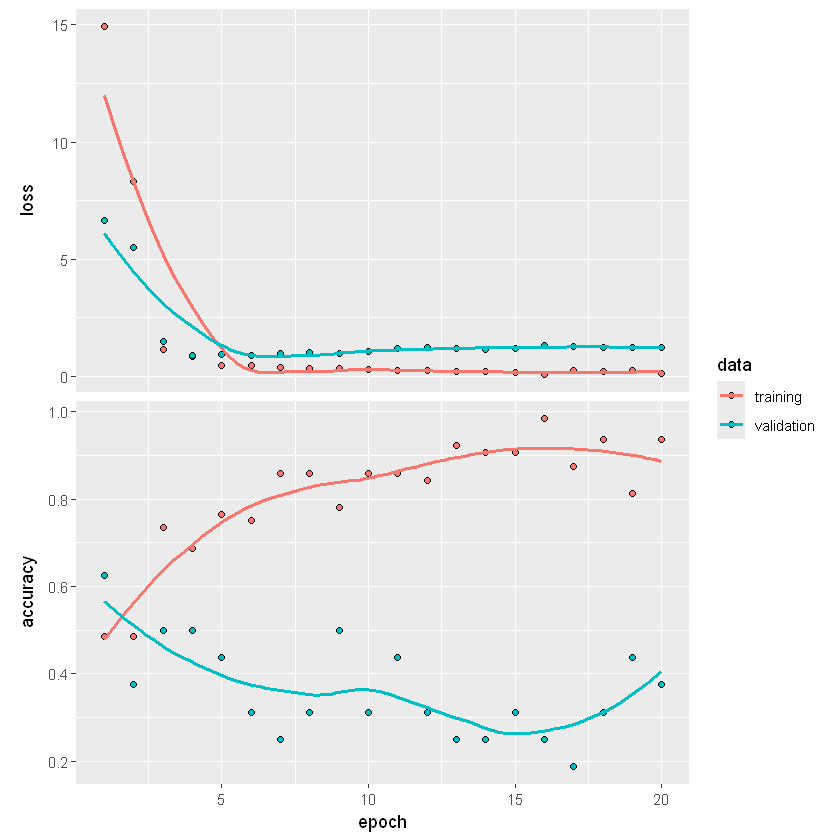

In [ ]:
model %>% evaluate(x_test, y_test)
plot(history)

### 1D CNN - V2 Deeper Network

A deeper 1D Convolutional Neural Network (CNN) designed for time-series data, incorporating multiple convolutional layers, batch normalization, pooling, and dropout for robust feature extraction and classification.

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `176 x 110`).

2. **Convolutional Block 1**:
   - **Conv1D**: 64 filters, kernel size = 5, activation = ReLU.
   - **Batch Normalization**: Normalizes activations to improve training stability.
   - **Max Pooling**: Pool size = 2, reduces spatial dimensions.
   - **Dropout**: Rate = 0.3, prevents overfitting.

3. **Convolutional Block 2**:
   - **Conv1D**: 128 filters, kernel size = 5, activation = ReLU.
   - **Batch Normalization**: Normalizes activations.
   - **Max Pooling**: Pool size = 2.
   - **Dropout**: Rate = 0.3.

4. **Convolutional Block 3**:
   - **Conv1D**: 256 filters, kernel size = 3, activation = ReLU.
   - **Batch Normalization**: Normalizes activations.
   - **Global Average Pooling**: Reduces each feature map to a single value.

5. **Fully Connected Layers**:
   - **Dense**: 64 units, activation = ReLU.
   - **Dropout**: Rate = 0.5.
   - **Dense**: 1 unit, activation = Sigmoid (for binary classification).

#### Compilation:
- **Optimizer**: Adam.
- **Loss Function**: Binary Crossentropy.
- **Metrics**: Accuracy.

In [ ]:
input_shape <- c(176, 110) # [timesteps, features]
x_train <- array_reshape(x_train, dim = c(dim(x_train)[1], 176, 110))
x_test  <- array_reshape(x_test, dim = c(dim(x_test)[1], 176, 110))

model <- keras_model_sequential() %>%
  layer_conv_1d(filters = 64, kernel_size = 5, activation = 'relu', input_shape = c(176, 110)) %>%
  layer_batch_normalization() %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(rate = 0.3) %>%

  layer_conv_1d(filters = 128, kernel_size = 5, activation = 'relu') %>%
  layer_batch_normalization() %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(rate = 0.3) %>%

  layer_conv_1d(filters = 256, kernel_size = 3, activation = 'relu') %>%
  layer_batch_normalization() %>%
  layer_global_average_pooling_1d() %>%

  layer_dense(units = 64, activation = 'relu') %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 1, activation = 'sigmoid')

model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = 'accuracy'
)

history <- model %>% fit(
  x = x_train,
  y = y_train,
  epochs = 30,
  batch_size = 8,
  validation_split = 0.2
)

loss  accuracy 
0.6766906 0.7500000

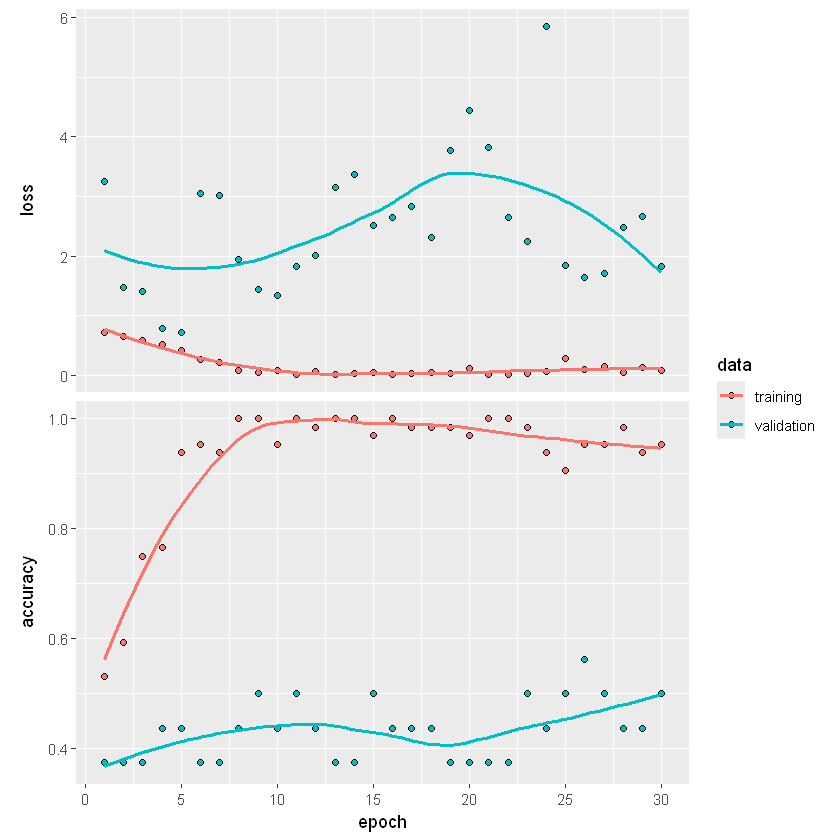

In [129]:
model %>% evaluate(x_test, y_test)
plot(history)

### Hyperparameter tuning & Cross Validation - 1D CNN

   filters kernel_size depth dropout_rate use_batch_norm mean_accuracy
74      64           3     2          0.3          FALSE        0.5875
     loss  accuracy 
0.7967846 0.6000000 
Model: "model_2726"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_2745 (InputLayer)            [(None, 176, 110)]              0           
 conv1d_4162 (Conv1D)               (None, 174, 64)                 21184       
 max_pooling1d_4137 (MaxPooling1D)  (None, 87, 64)                  0           
 dropout_7898 (Dropout)             (None, 87, 64)                  0           
 conv1d_4163 (Conv1D)               (None, 85, 64)                  12352       
 max_pooling1d_4138 (MaxPooling1D)  (None, 42, 64)                  0           
 dropout_7899 (Dropout)             (None, 42, 64)                  0           
 flatten_1115 (Flatten)             (None, 2688)                   

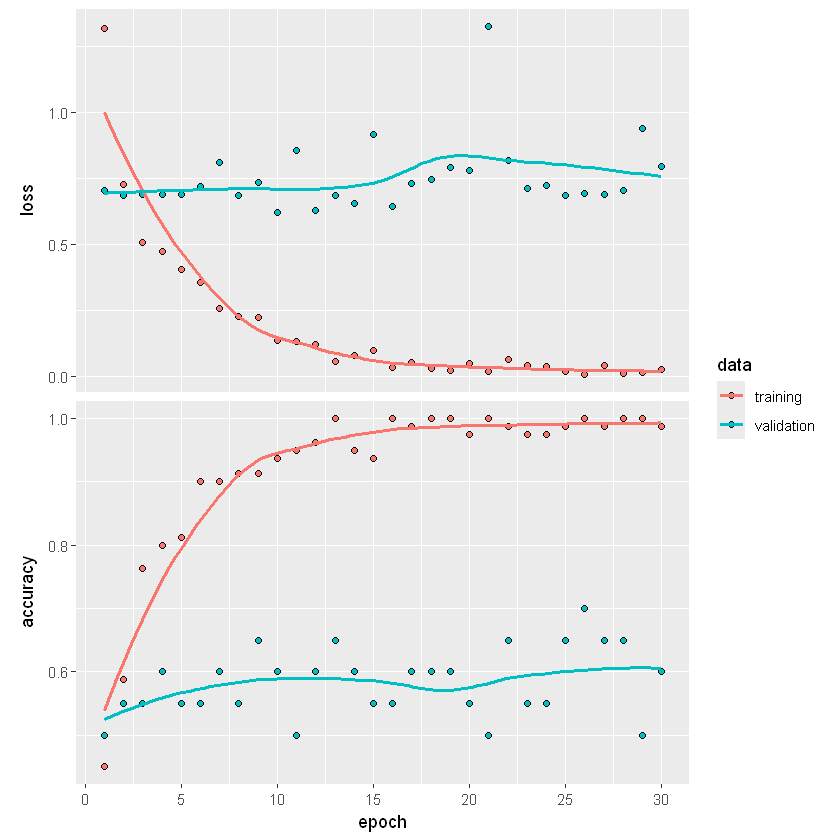

In [211]:
# Define a function to create 1D CNN models with optional batch normalization and varying depths
create_cnn_model <- function(filters = 64, kernel_size = 3, depth = 2, dropout_rate = 0.3, use_batch_norm = FALSE) {
  input <- layer_input(shape = c(176, 110))
  
  # Add convolutional layers with optional batch normalization based on the depth
  cnn_out <- input
  for (i in seq_len(depth)) {
    cnn_out <- cnn_out %>%
      layer_conv_1d(filters = filters, kernel_size = kernel_size, activation = "relu")
    
    if (use_batch_norm) {
      cnn_out <- cnn_out %>%
        layer_batch_normalization()  # Add batch normalization if enabled
    }
    
    cnn_out <- cnn_out %>%
      layer_max_pooling_1d(pool_size = 2) %>%
      layer_dropout(rate = dropout_rate)
  }
  
  # Fully connected layers
  output <- cnn_out %>%
    layer_flatten() %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = 2, activation = "softmax")
  
  # Build and compile the model
  model <- keras_model(inputs = input, outputs = output)
  model %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = "accuracy"
  )
  
  return(model)
}

# Define hyperparameter grid
hyper_grid <- expand.grid(
  filters = c(32, 64, 128),
  kernel_size = c(3, 5),
  depth = c(2, 3, 4),  # Different depths of the network
  dropout_rate = c(0.2, 0.3, 0.4),
  use_batch_norm = c(TRUE, FALSE)  # Include batch normalization as a hyperparameter
)

# Cross-validation setup
k_folds <- 5
cv_results <- data.frame()

# Generate fold indices manually
set.seed(123)
fold_indices <- split(seq_len(dim(X_train)[1]), rep(1:k_folds, length.out = dim(X_train)[1]))

# Perform k-fold cross-validation
for (i in seq_len(nrow(hyper_grid))) {
  params <- hyper_grid[i, ]
  fold_accuracies <- c()
  
  for (fold in seq_len(k_folds)) {
    # Split data into training and validation sets
    val_indices <- fold_indices[[fold]]
    train_indices <- setdiff(seq_len(dim(X_train)[1]), val_indices)
    
    X_train_fold <- X_train[train_indices, , ]
    y_train_fold <- y_train[train_indices, ]
    X_val_fold <- X_train[val_indices, , ]
    y_val_fold <- y_train[val_indices, ]
    
    # Create and train the model
    model <- create_cnn_model(
      filters = params$filters,
      kernel_size = params$kernel_size,
      depth = params$depth,
      dropout_rate = params$dropout_rate,
      use_batch_norm = params$use_batch_norm
    )
    
    history <- model %>% fit(
      X_train_fold, y_train_fold,
      epochs = 10,  # Use fewer epochs for faster tuning
      batch_size = 8,
      validation_data = list(X_val_fold, y_val_fold),
      verbose = 0
    )
    
    # Evaluate on validation set
    eval_result <- model %>% evaluate(X_val_fold, y_val_fold, verbose = 0)
    val_accuracy <- eval_result[[2]]  # Accuracy is the second element
    fold_accuracies <- c(fold_accuracies, val_accuracy)
  }
  
  # Store results
  mean_accuracy <- mean(fold_accuracies)
  cv_results <- rbind(cv_results, cbind(params, mean_accuracy))
}

# Find the best hyperparameters
best_params <- cv_results[which.max(cv_results$mean_accuracy), ]
print(best_params)

# Train the final model with the best hyperparameters
final_model <- create_cnn_model(
  filters = best_params$filters,
  kernel_size = best_params$kernel_size,
  depth = best_params$depth,
  dropout_rate = best_params$dropout_rate,
  use_batch_norm = best_params$use_batch_norm
)

history <- final_model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate the final model
final_eval <- final_model %>% evaluate(X_test, y_test)
print(final_eval)
summary(final_model)
plot(history)

#### Extended CV for 1D-CNN

In [54]:
# Updated model creation function with more flexibility
create_cnn_model <- function(filters = c(64, 128), 
                             kernel_size = 3, 
                             depth = 3, 
                             dropout_rate = 0.3, 
                             dense_units = 64, 
                             use_batch_norm = FALSE, 
                             pool_type = "max", 
                             activation = "relu",
                             optimizer = "adam") {
  
  input <- layer_input(shape = c(176, 110))
  cnn_out <- input
  
  # Add convolutional blocks
  for (i in seq_len(depth)) {
    layer_filters <- if (length(filters) == 1) filters else filters[min(i, length(filters))]
    
    cnn_out <- cnn_out %>%
      layer_conv_1d(filters = layer_filters, kernel_size = kernel_size, activation = activation, padding = "same")
    
    if (use_batch_norm) {
      cnn_out <- cnn_out %>% layer_batch_normalization()
    }
    
    if (pool_type == "max") {
      cnn_out <- cnn_out %>% layer_max_pooling_1d(pool_size = 2)
    } else {
      cnn_out <- cnn_out %>% layer_average_pooling_1d(pool_size = 2)
    }
    
    cnn_out <- cnn_out %>% layer_dropout(rate = dropout_rate)
  }
  
  # Fully connected layers
  output <- cnn_out %>%
    layer_flatten() %>%
    layer_dense(units = dense_units, activation = activation) %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = 2, activation = "softmax")
  
  model <- keras_model(inputs = input, outputs = output)
  model %>% compile(
    optimizer = optimizer,
    loss = "categorical_crossentropy",
    metrics = "accuracy"
  )
  
  return(model)
}

# Expanded hyperparameter grid
hyper_grid <- expand.grid(
  filters = I(list(c(64), c(64, 128))),  # Single or increasing filters
  kernel_size = c(3, 5, 7),
  depth = c(2, 3, 4, 5),
  dropout_rate = c(0.2, 0.3, 0.4, 0.5),
  dense_units = c(32, 64, 128),
  use_batch_norm = c(TRUE, FALSE),
  pool_type = c("max", "average"),
  activation = c("relu", "elu", "selu"),
  optimizer = c("adam", "rmsprop"),
  stringsAsFactors = FALSE
)

# Cross-validation setup
k_folds <- 5
cv_results <- data.frame()
set.seed(123)
fold_indices <- split(seq_len(dim(X_train)[1]), rep(1:k_folds, length.out = dim(X_train)[1]))

# Loop through grid
for (i in seq_len(nrow(hyper_grid))) {
  params <- hyper_grid[i, ]
  fold_accuracies <- c()
  
  for (fold in seq_len(k_folds)) {
    val_idx <- fold_indices[[fold]]
    train_idx <- setdiff(seq_len(dim(X_train)[1]), val_idx)
    
    X_train_fold <- X_train[train_idx, , ]
    y_train_fold <- y_train[train_idx, ]
    X_val_fold <- X_train[val_idx, , ]
    y_val_fold <- y_train[val_idx, ]
    
    # Build and train model
    model <- create_cnn_model(
      filters = params$filters[[1]],
      kernel_size = params$kernel_size,
      depth = params$depth,
      dropout_rate = params$dropout_rate,
      dense_units = params$dense_units,
      use_batch_norm = params$use_batch_norm,
      pool_type = params$pool_type,
      activation = params$activation,
      optimizer = params$optimizer
    )
    
    history <- model %>% fit(
      X_train_fold, y_train_fold,
      epochs = 10,
      batch_size = 8,
      validation_data = list(X_val_fold, y_val_fold),
      verbose = 0
    )
    
    eval_result <- model %>% evaluate(X_val_fold, y_val_fold, verbose = 0)
    val_accuracy <- eval_result[[2]]
    fold_accuracies <- c(fold_accuracies, val_accuracy)
  }
  
  mean_accuracy <- mean(fold_accuracies)
  cv_results <- bind_rows(cv_results, cbind(params, mean_accuracy))
  cat(sprintf("Completed model %d/%d - Accuracy: %.4f\n", i, nrow(hyper_grid), mean_accuracy))
}

# Best model selection
best_params <- cv_results %>% filter(mean_accuracy == max(mean_accuracy)) %>% slice(1)
print(best_params)

# Final training on best model
final_model <- create_cnn_model(
  filters = best_params$filters[[1]],
  kernel_size = best_params$kernel_size,
  depth = best_params$depth,
  dropout_rate = best_params$dropout_rate,
  dense_units = best_params$dense_units,
  use_batch_norm = best_params$use_batch_norm,
  pool_type = best_params$pool_type,
  activation = best_params$activation,
  optimizer = best_params$optimizer
)

history <- final_model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

final_eval <- final_model %>% evaluate(X_test, y_test)
print(final_eval)
summary(final_model)
plot(history)

ERROR: Error in split(seq_len(dim(X_train)[1]), rep(1:k_folds, length.out = dim(X_train)[1])): object 'X_train' not found


### CV 1D-CNN tsfeatures

In [71]:
# Gather features into long format
features_long <- features_df %>%
  pivot_longer(cols = starts_with("V"), names_to = "Feature", values_to = "Value")

# Combine Region and Feature names to create unique column names
features_long <- features_long %>%
  unite("Region_Feature", Region, Feature, sep = "_")

# Pivot to wide format: one row per Subject
features_wide <- features_long %>%
  pivot_wider(names_from = Region_Feature, values_from = Value)

# Confirm Group is missing here
if(!"Group" %in% colnames(features_wide)) {
  # Add Group info back from original data (taking first occurrence per Subject)
  subject_groups <- features_df %>%
    select(Subject, Group) %>%
    distinct()
  
  features_wide <- features_wide %>%
    left_join(subject_groups, by = "Subject")
}

# Now check columns
print(colnames(features_wide))

   [1] "Subject"      "Group"        "mean_V1"      "mean_V2"     
   [5] "mean_V3"      "mean_V4"      "mean_V5"      "mean_V6"     
   [9] "mean_V7"      "mean_V8"      "mean_V9"      "mean_V10"    
  [13] "mean_V11"     "mean_V12"     "mean_V13"     "mean_V14"    
  [17] "mean_V15"     "mean_V16"     "mean_V17"     "mean_V18"    
  [21] "mean_V19"     "mean_V20"     "mean_V21"     "mean_V22"    
  [25] "mean_V23"     "mean_V24"     "mean_V25"     "mean_V26"    
  [29] "mean_V27"     "mean_V28"     "mean_V29"     "mean_V30"    
  [33] "mean_V31"     "mean_V32"     "mean_V33"     "mean_V34"    
  [37] "mean_V35"     "mean_V36"     "mean_V37"     "mean_V38"    
  [41] "mean_V39"     "mean_V40"     "mean_V41"     "mean_V42"    
  [45] "mean_V43"     "mean_V44"     "mean_V45"     "mean_V46"    
  [49] "mean_V47"     "mean_V48"     "mean_V49"     "mean_V50"    
  [53] "mean_V51"     "mean_V52"     "mean_V53"     "mean_V54"    
  [57] "mean_V55"     "mean_V56"     "mean_V57"     "mean_V58"

In [80]:
# drop NAs
features_wide <- features_wide %>% drop_na()

In [90]:
# Prepare wide matrix (replace NA with 0)
X_mat <- features_wide %>%
  dplyr::select(-Subject, -Group) %>%
  mutate_all(~as.numeric(replace(., is.na(.), 0))) %>%
  as.matrix()

# Prepare label vector (one-hot encode)
group_labels <- features_wide$Group
y <- to_categorical(as.numeric(as.factor(group_labels)) - 1, num_classes = 2)

# Reshape X to 3D for CNN
X <- array(X_mat, dim = c(nrow(X_mat), ncol(X_mat), 1))

# Check dimensions
cat("X shape:", dim(X), "\n")
cat("y shape:", dim(y), "\n")


X shape: 99 5720 1 
y shape: 99 2 


In [83]:
create_tsfeatures_cnn_model <- function(filters = 64, kernel_size = 3, depth = 2, dropout_rate = 0.3, use_batch_norm = FALSE) {
  input <- layer_input(shape = c(dim(X)[2], 1))
  cnn_out <- input

  for (i in seq_len(depth)) {
    cnn_out <- cnn_out %>%
      layer_conv_1d(filters = filters, kernel_size = kernel_size, activation = "relu", padding = "same")
    if (use_batch_norm) {
      cnn_out <- cnn_out %>% layer_batch_normalization()
    }
    cnn_out <- cnn_out %>%
      layer_max_pooling_1d(pool_size = 2) %>%
      layer_dropout(rate = dropout_rate)
  }

  output <- cnn_out %>%
    layer_flatten() %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = 2, activation = "softmax")

  model <- keras_model(inputs = input, outputs = output)
  model %>% compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = "accuracy")
  return(model)
}

In [91]:
set.seed(123)
k_folds <- 5
n_samples <- dim(X)[1]
fold_assignments <- sample(rep(1:k_folds, length.out = n_samples))

# Define hyperparameter grid
hyper_grid <- expand.grid(
  filters = c(32, 64),
  kernel_size = c(3, 5),
  depth = c(2, 3),
  dropout_rate = c(0.3, 0.4),
  use_batch_norm = c(TRUE, FALSE)
)

cv_results <- data.frame()

for (i in seq_len(nrow(hyper_grid))) {
  params <- hyper_grid[i, ]
  fold_accuracies <- c()

  for (fold in 1:k_folds) {
    val_idx <- which(fold_assignments == fold)
    train_idx <- setdiff(seq_len(n_samples), val_idx)

    model <- create_tsfeatures_cnn_model(
      filters = params$filters,
      kernel_size = params$kernel_size,
      depth = params$depth,
      dropout_rate = params$dropout_rate,
      use_batch_norm = params$use_batch_norm
    )

    history <- model %>% fit(
      X[train_idx, , , drop = FALSE], y[train_idx, , drop = FALSE],
      epochs = 10,
      batch_size = 8,
      validation_data = list(X[val_idx, , , drop = FALSE], y[val_idx, , drop = FALSE]),
      verbose = 0
    )

    eval <- model %>% evaluate(X[val_idx, , , drop = FALSE], y[val_idx, , drop = FALSE], verbose = 0)
    fold_accuracies <- c(fold_accuracies, eval["accuracy"])
  }

  mean_acc <- mean(fold_accuracies)
  cv_results <- rbind(cv_results, cbind(params, mean_accuracy = mean_acc))
  cat("Completed config", i, "of", nrow(hyper_grid), "- Mean Accuracy:", round(mean_acc, 4), "\n")
}

Completed config 1 of 32 - Mean Accuracy: 0.5042 
Completed config 2 of 32 - Mean Accuracy: 0.5042 
Completed config 3 of 32 - Mean Accuracy: 0.5042 
Completed config 4 of 32 - Mean Accuracy: 0.5042 
Completed config 5 of 32 - Mean Accuracy: 0.5042 
Completed config 6 of 32 - Mean Accuracy: 0.5042 
Completed config 7 of 32 - Mean Accuracy: 0.5042 
Completed config 8 of 32 - Mean Accuracy: 0.5042 
Completed config 9 of 32 - Mean Accuracy: 0.5042 
Completed config 10 of 32 - Mean Accuracy: 0.5042 
Completed config 11 of 32 - Mean Accuracy: 0.5042 
Completed config 12 of 32 - Mean Accuracy: 0.5042 
Completed config 13 of 32 - Mean Accuracy: 0.5042 
Completed config 14 of 32 - Mean Accuracy: 0.5042 
Completed config 15 of 32 - Mean Accuracy: 0.5042 
Completed config 16 of 32 - Mean Accuracy: 0.5042 
Completed config 17 of 32 - Mean Accuracy: 0.5042 
Completed config 18 of 32 - Mean Accuracy: 0.5042 
Completed config 19 of 32 - Mean Accuracy: 0.5042 
Completed config 20 of 32 - Mean Accurac

     loss  accuracy 
      NaN 0.5050505 


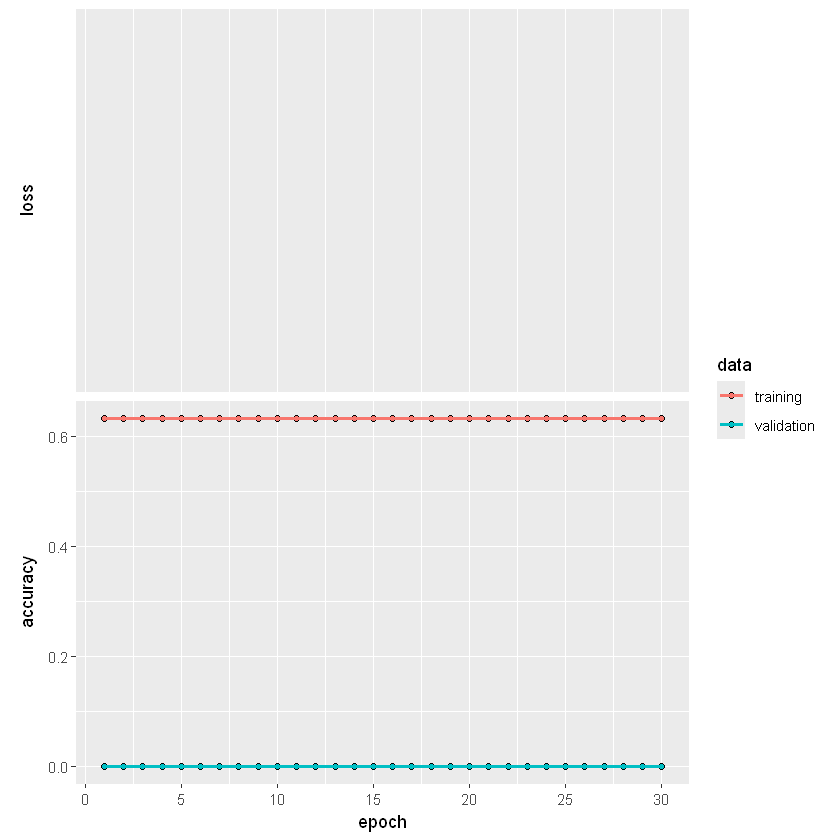

In [92]:
best_params <- cv_results[which.max(cv_results$mean_accuracy), ]

final_model <- create_tsfeatures_cnn_model(
  filters = best_params$filters,
  kernel_size = best_params$kernel_size,
  depth = best_params$depth,
  dropout_rate = best_params$dropout_rate,
  use_batch_norm = best_params$use_batch_norm
)

history <- final_model %>% fit(
  X, y,
  epochs = 30,
  batch_size = 8,
  validation_split = 0.2
)

plot(history)
final_eval <- final_model %>% evaluate(X, y)
print(final_eval)


In [ ]:
head(features_wide[, c("Subject", "Group")])
table(features_wide$Group)

Subject,Group
<chr>,<chr>
ASD_1,ASD
ASD_2,ASD
ASD_3,ASD
ASD_4,ASD
ASD_5,ASD
ASD_6,ASD



   ASD Normal 
    50     49 

## RNN - Recurrent Neural Networks

### Data Processing for Categorical Classification (LSTM - Transformer)

To prepare the data for LSTM models, the following steps are performed to ensure the data is in the correct format for time-series analysis:

 1. **Normalization**
    - Normalize the signal data to ensure all features have a mean of 0 and a standard deviation of 1.
    - This is done per subject and brain region to standardize the input data.

 2. **Extract Time Points and Regions**
    - Identify the number of time points (`n_timepoints`) and brain regions (`n_regions`) from the dataset.
    - Ensure all subjects have the same number of time points by padding shorter sequences with zeros.

 3. **Reshape Data**
    - Convert the data for each subject into a matrix of shape `(n_timepoints, n_regions)`, where:
        - Rows represent time points.
        - Columns represent brain regions.
    - Stack these matrices into a 3D array of shape `(n_subjects, n_timepoints, n_regions)`.

 4. **Label Encoding**
    - Encode the group labels (e.g., "ASD" and "Normal") into numerical values:
        - Use `0` for "ASD" and `1` for "Normal".
    - Convert the labels into one-hot encoded format for categorical classification.

 5. **Train-Test Split**
    - Split the data into training and testing sets:
        - Use 80% of the subjects for training and 20% for testing.
    - Ensure the split is stratified to maintain the class distribution.

In [ ]:
# Use normalized signal data
normalized_all_data_long$Subject <- as.character(normalized_all_data_long$Subject)
normalized_all_data_long$RegionName <- as.character(normalized_all_data_long$RegionName)

n_timepoints <- 176
region_names <- sort(unique(all_data_long$RegionName))
subject_ids <- sort(unique(all_data_long$Subject))
n_regions <- length(region_names)

subject_matrices <- list()
labels <- c()

for (subj in subject_ids) {
  subj_data <- normalized_all_data_long %>%
    filter(Subject == subj) %>%
    select(Time, RegionName, Signal_Z, Group) %>%
    pivot_wider(names_from = RegionName, values_from = Signal_Z) %>%
    arrange(Time) %>%
    select(all_of(region_names))

  mat <- as.matrix(subj_data)
  
  # Pad to ensure 176 timepoints
  if (nrow(mat) < n_timepoints) {
    pad <- matrix(0, nrow = n_timepoints - nrow(mat), ncol = n_regions)
    mat <- rbind(mat, pad)
  }

  subject_matrices[[length(subject_matrices) + 1]] <- mat[1:n_timepoints, ]
  
  # Extract label from original dataset
  group_label <- all_data_long %>%
    filter(Subject == subj) %>%
    distinct(Group) %>%
    pull(Group) %>%
    unique()

  labels <- c(labels, group_label)
}

# Stack 3D array: (subjects, time, regions)
X <- abind::abind(subject_matrices, along = 0)

# Encode labels
y <- as.numeric(factor(labels, levels = c("ASD", "Normal"))) - 1  # ASD=0, Normal=1
y_cat <- to_categorical(y, num_classes = 2)

set.seed(123)
train_indices <- sample(1:100, size = 0.8 * 100)

X_train <- X[train_indices, , ]
y_train <- y_cat[train_indices, ]
X_test <- X[-train_indices, , ]
y_test <- y_cat[-train_indices, ]

### LSTM

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `176 x 110` for 176 time steps and 110 features).

2. **LSTM Layer**:
   - **LSTM**: 64 units, processes sequential data and captures temporal dependencies.
   - **Dropout**: Rate = 0.3, prevents overfitting by randomly dropping connections.

3. **Fully Connected Layers**:
   - **Dense**: 32 units, activation = ReLU.
   - **Dropout**: Rate = 0.3.
   - **Dense**: 2 units, activation = Softmax (for binary classification).

#### Compilation:
- **Optimizer**: Adam (learning rate = 0.001).
- **Loss Function**: Categorical Crossentropy.
- **Metrics**: Accuracy.

loss  accuracy 
0.9662452 0.7500000

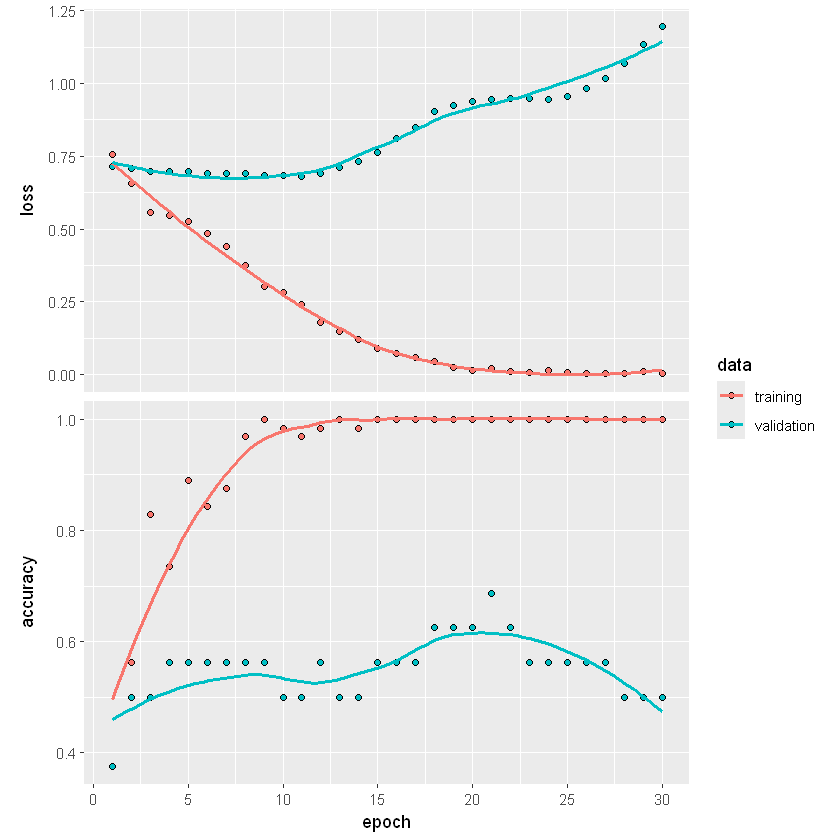

In [ ]:
model <- keras_model_sequential() %>%
  layer_lstm(units = 64, input_shape = c(176, 110), return_sequences = FALSE) %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 32, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 2, activation = 'softmax')

model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_adam(learning_rate = 0.001),
  metrics = c('accuracy')
)

history <- model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_split = 0.2
)

model %>% evaluate(X_test, y_test)
plot(history)

### LSTM + attention

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `176 x 110` for 176 time steps and 110 features).

2. **LSTM Layer**:
   - **LSTM**: 64 units, processes sequential data and outputs sequences for attention.

3. **Attention Mechanism**:
   - Computes attention weights for each time step.
   - Applies the attention weights to the LSTM outputs to focus on the most relevant time steps.

4. **Fully Connected Layers**:
   - **Dense**: 64 units, activation = ReLU.
   - **Dropout**: Rate = 0.3.
   - **Dense**: 2 units, activation = Softmax (for binary classification).

#### Compilation:
- **Optimizer**: Adam.
- **Loss Function**: Categorical Crossentropy.
- **Metrics**: Accuracy.

loss  accuracy 
0.6436275 0.7500000

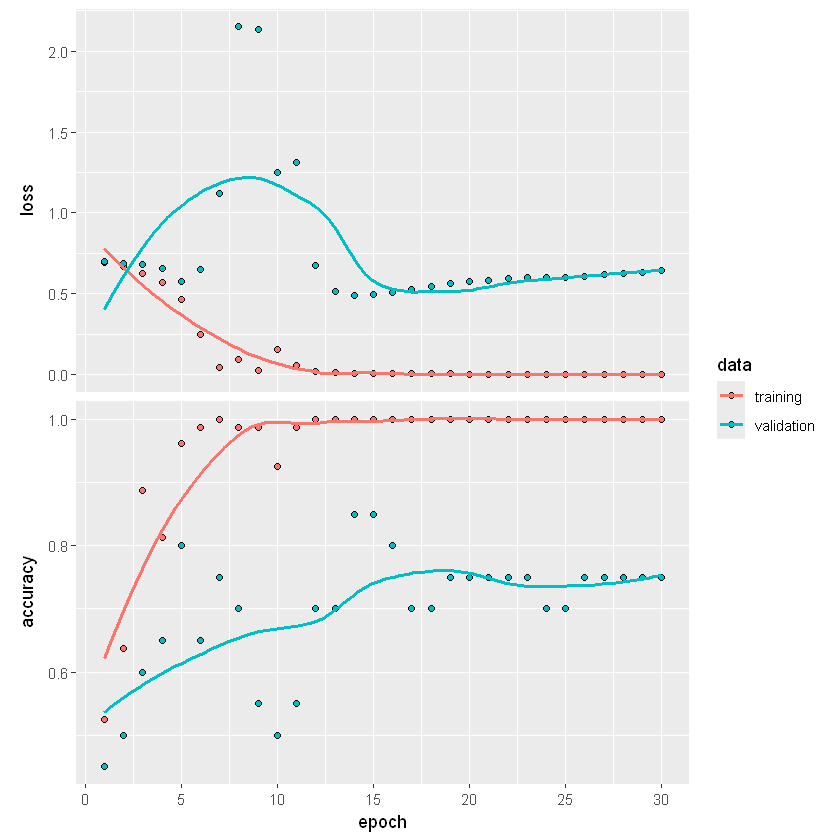

In [150]:
# Input shape: (time, regions)
input <- layer_input(shape = c(176, 110))

# LSTM Layer (forward only)
lstm_out <- input %>%
  layer_lstm(units = 64, return_sequences = TRUE)

# Attention Mechanism
attention <- lstm_out %>%
  time_distributed(layer_dense(units = 1)) %>%
  layer_reshape(target_shape = c(176)) %>%
  layer_activation("softmax") %>%
  layer_repeat_vector(64) %>%
  layer_permute(c(2, 1))

# Apply attention to LSTM outputs
attended <- layer_multiply(list(lstm_out, attention)) %>%
  layer_lambda(function(x) k_sum(x, axis = 2))

# Fully connected layers
output <- attended %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(0.3) %>%
  layer_dense(units = 2, activation = "softmax")

# Compile model
model <- keras_model(inputs = input, outputs = output)
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = "accuracy"
)

# Train
history <- model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate
model %>% evaluate(X_test, y_test)
plot(history)

### Bidirectional LSTM + attention

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `176 x 110` for 176 time steps and 110 features).

2. **Bidirectional LSTM Layer**:
   - **Bidirectional LSTM**: 64 units, processes sequential data in both forward and backward directions and outputs sequences for attention.

3. **Feature Reduction**:
   - **Dense Layer**: Reduces the feature size to 64 to match the attention mechanism.

4. **Attention Mechanism**:
   - Computes attention weights for each time step.
   - Applies the attention weights to the LSTM outputs to focus on the most relevant time steps.

5. **Fully Connected Layers**:
   - **Dense**: 64 units, activation = ReLU.
   - **Dropout**: Rate = 0.3.
   - **Dense**: 2 units, activation = Softmax (for binary classification).

#### Compilation:
- **Optimizer**: Adam.
- **Loss Function**: Categorical Crossentropy.
- **Metrics**: Accuracy.

loss accuracy 
1.144428 0.750000

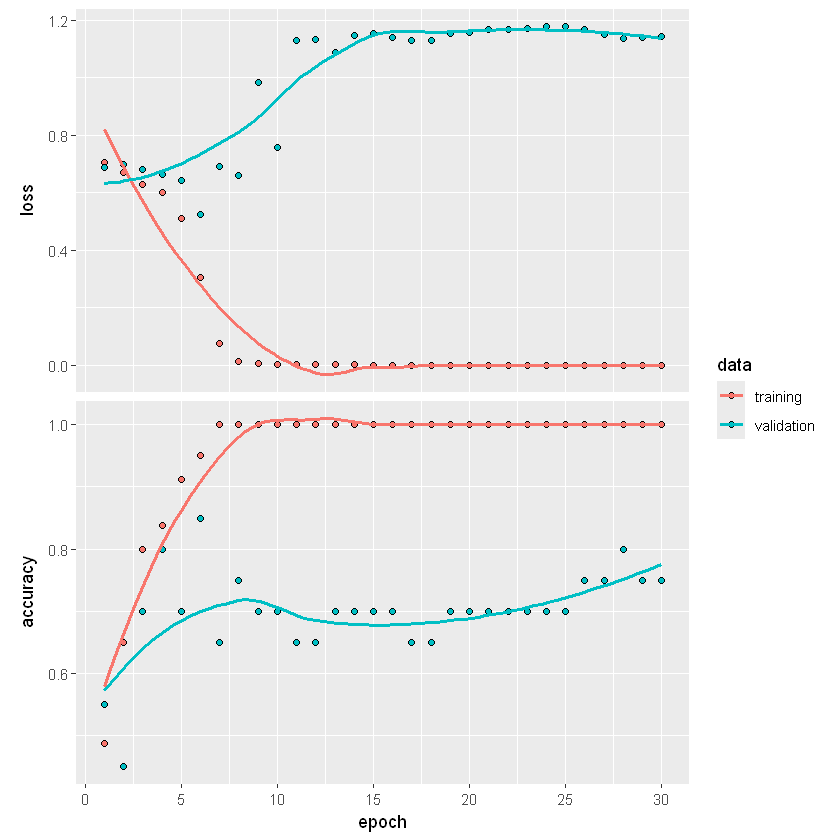

In [177]:
# Input shape: (time, regions)
input <- layer_input(shape = c(176, 110))

# Bidirectional LSTM layer (return sequences for attention)
bi_lstm_out <- input %>%
  bidirectional(layer_lstm(units = 64, return_sequences = TRUE))

# Reduce feature size to 64 after Bidirectional LSTM (to match attention mechanism)
bi_lstm_out_reduced <- bi_lstm_out %>%
  layer_dense(units = 64, activation = "relu")

# Attention Mechanism
attention <- bi_lstm_out_reduced %>%
  time_distributed(layer_dense(units = 1)) %>%  # Apply dense to each time step
  layer_reshape(target_shape = c(176)) %>%  # Flatten the time axis (176)
  layer_activation("softmax") %>%  # Apply softmax across time
  layer_repeat_vector(64) %>%  # Match the features (64 units)
  layer_permute(c(2, 1))  # Permute for correct shape (features, time)

# Apply attention to LSTM outputs
attended <- layer_multiply(list(bi_lstm_out_reduced, attention)) %>%
  layer_lambda(function(x) k_sum(x, axis = 2))  # Sum across the time dimension

# Fully connected layers
output <- attended %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(0.3) %>%
  layer_dense(units = 2, activation = "softmax")

# Compile model
model <- keras_model(inputs = input, outputs = output)
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = "accuracy"
)

# Train
history <- model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate
model %>% evaluate(X_test, y_test)
plot(history)


### LSTM + self-attention

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `176 x 110` for 176 time steps and 110 features).

2. **LSTM Layer**:
   - **LSTM**: 64 units, processes sequential data and outputs sequences for attention.

3. **Self-Attention Mechanism**:
   - Dense projections for Query (Q), Key (K), and Value (V).
   - Computes attention scores using scaled dot-product attention.
   - Applies attention weights to the Value matrix to focus on important time steps.

4. **Global Average Pooling**:
   - Reduces the attention output to a fixed-size vector.

5. **Fully Connected Layers**:
   - **Dense**: 64 units, activation = ReLU.
   - **Dropout**: Rate = 0.3.
   - **Dense**: 2 units, activation = Softmax (for binary classification).

#### Compilation:
- **Optimizer**: Adam.
- **Loss Function**: Categorical Crossentropy.
- **Metrics**: Accuracy.

loss accuracy 
1.236043 0.600000

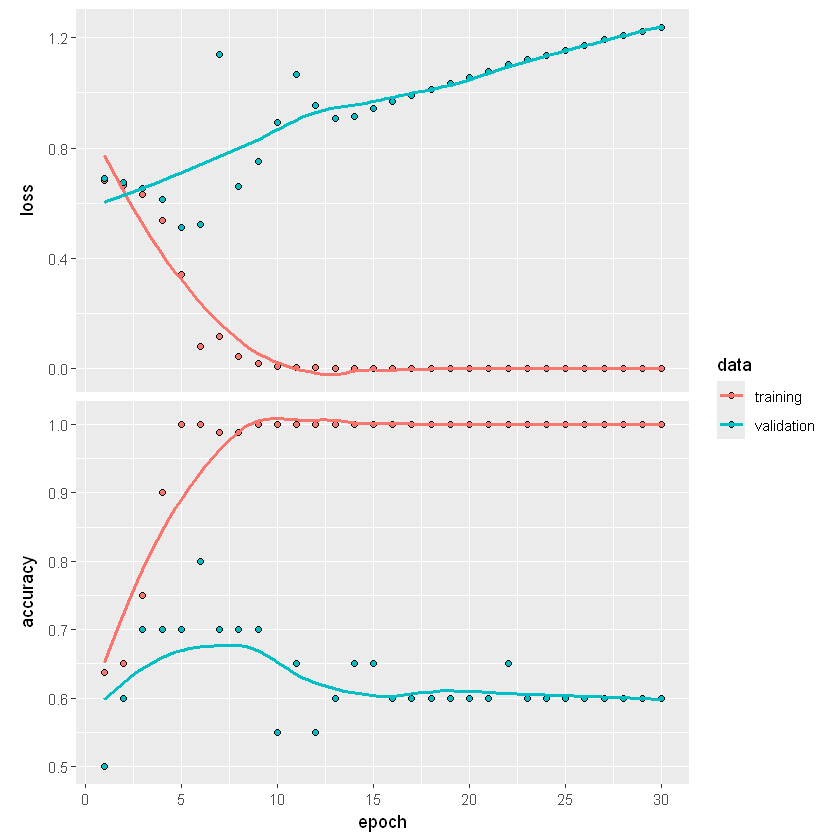

In [154]:
# Input shape: (time steps = 176, features = 110)
input <- layer_input(shape = c(176, 110))

# LSTM layer (return sequences for attention)
lstm_out <- input %>%
  layer_lstm(units = 64, return_sequences = TRUE)

# Dense projections for Q, K, V
query <- lstm_out %>% layer_dense(units = 64)
key   <- lstm_out %>% layer_dense(units = 64)
value <- lstm_out %>% layer_dense(units = 64)

# Attention score computation (scaled dot-product)
scores <- layer_lambda(
  f = function(x) {
    tf$matmul(x[[1]], tf$transpose(x[[2]], perm = c(0L, 2L, 1L))) / sqrt(64)
  }
)(list(query, key))

# Attention weights (softmax over last axis)
weights <- scores %>% layer_activation("softmax")

# Weighted sum of values
attention_output <- layer_lambda(
  f = function(x) {
    tf$matmul(x[[1]], x[[2]])
  }
)(list(weights, value))

# Global average pooling
pooled <- attention_output %>%
  layer_global_average_pooling_1d()

# Dense output layers
output <- pooled %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 2, activation = "softmax")

# Build model
model <- keras_model(inputs = input, outputs = output)

# Compile
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = "accuracy"
)

# Train
history <- model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate
model %>% evaluate(X_test, y_test)
plot(history)

### Bidirectional LSTM + self attention

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `176 x 110` for 176 time steps and 110 features).

2. **Bidirectional LSTM Layer**:
   - **Bidirectional LSTM**: 64 units, processes sequential data in both forward and backward directions and outputs sequences for attention.

3. **Self-Attention Mechanism**:
   - Dense projections for Query (Q), Key (K), and Value (V).
   - Computes attention scores using scaled dot-product attention.
   - Applies attention weights to the Value matrix to focus on important time steps.

4. **Global Average Pooling**:
   - Reduces the attention output to a fixed-size vector.

5. **Fully Connected Layers**:
   - **Dense**: 64 units, activation = ReLU.
   - **Dropout**: Rate = 0.3.
   - **Dense**: 2 units, activation = Softmax (for binary classification).

#### Compilation:
- **Optimizer**: Adam.
- **Loss Function**: Categorical Crossentropy.
- **Metrics**: Accuracy.

loss accuracy 
2.928708 0.500000

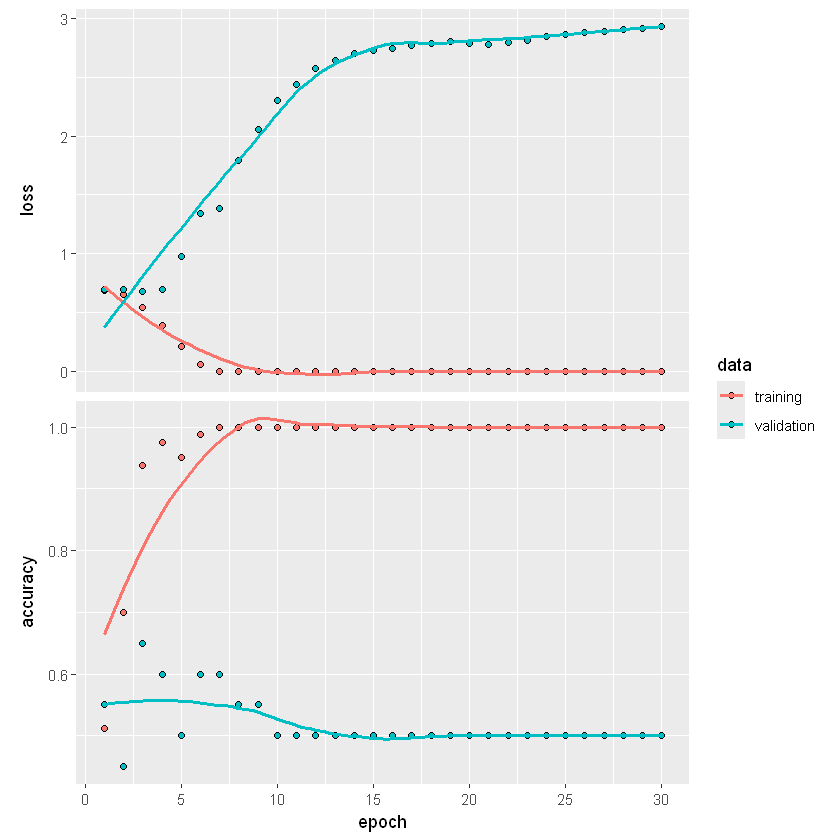

In [168]:
# Input shape: (time steps = 176, features = 110)
input <- layer_input(shape = c(176, 110))

# Bidirectional LSTM layer (return sequences for attention)
bi_lstm_out <- input %>%
  bidirectional(layer_lstm(units = 64, return_sequences = TRUE))

# Dense projections for Q, K, V
query <- bi_lstm_out %>% layer_dense(units = 64)
key   <- bi_lstm_out %>% layer_dense(units = 64)
value <- bi_lstm_out %>% layer_dense(units = 64)

# Attention score computation (scaled dot-product)
scores <- layer_lambda(
  f = function(x) {
    tf$matmul(x[[1]], tf$transpose(x[[2]], perm = c(0L, 2L, 1L))) / sqrt(64)
  }
)(list(query, key))

# Attention weights (softmax over last axis)
weights <- scores %>% layer_activation("softmax")

# Weighted sum of values
attention_output <- layer_lambda(
  f = function(x) {
    tf$matmul(x[[1]], x[[2]])
  }
)(list(weights, value))

# Global average pooling
pooled <- attention_output %>%
  layer_global_average_pooling_1d()

# Dense output layers
output <- pooled %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 2, activation = "softmax")

# Build model
model <- keras_model(inputs = input, outputs = output)

# Compile
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = "accuracy"
)

# Train
history <- model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate
model %>% evaluate(X_test, y_test)
plot(history)

### Hyperparameter tuning & Cross Validation - LSTM

         rnn_type units dropout_rate mean_accuracy
16 self_attention    32          0.3          0.65
    loss accuracy 
1.796965 0.600000 
Model: "model_1643"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_1662 (InputLayer)  [(None, 176, 110  0        []                         
                          )]                                                    
 lstm_712 (LSTM)          (None, 176, 32)   18304    ['input_1662[0][0]']       
 dense_5009 (Dense)       (None, 176, 32)   1056     ['lstm_712[0][0]']         
 dense_5010 (Dense)       (None, 176, 32)   1056     ['lstm_712[0][0]']         
 lambda_293 (Lambda)      (None, 176, 176)  0        ['dense_5009[0][0]',       
                                                      'dense_5010[0][0]']       
 activation_205 (Activati  (None, 176, 176)  0       ['lambda_293[0][0]']       
 on)                          

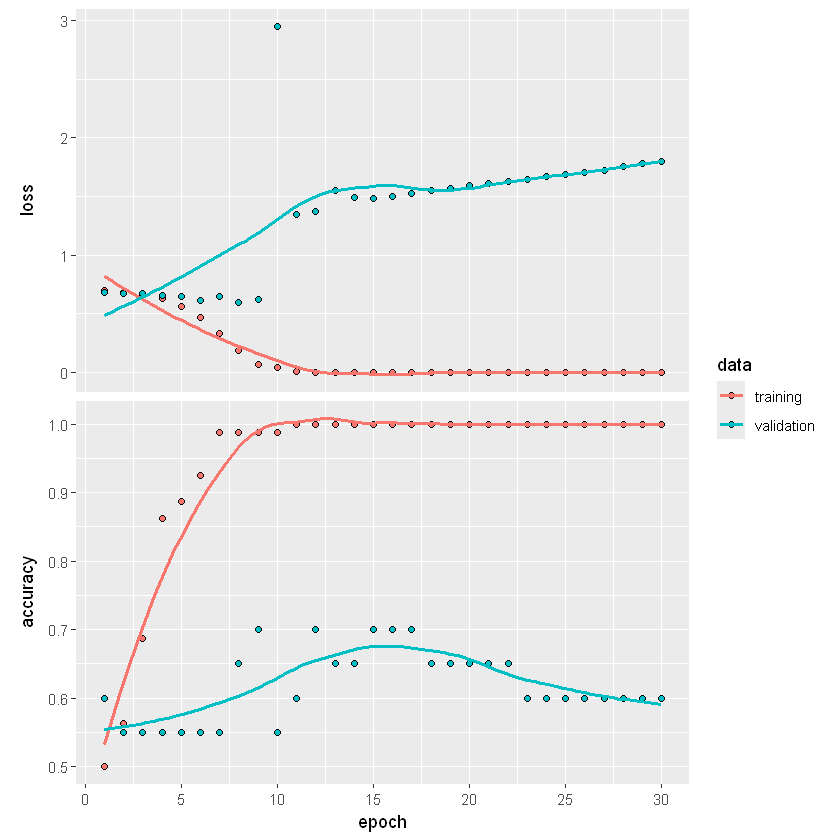

In [207]:
# attention mechanism in create_rnn_model
create_rnn_model <- function(
  rnn_type = "attention",  # Options: "lstm", "bidirectional", "attention", "self_attention"
  units = 64,
  dropout_rate = 0.3,
  input_shape = c(176, 110)
) {
  input <- layer_input(shape = input_shape)
  
  # Add RNN layers based on the type
  rnn_out <- switch(
    rnn_type,
    "lstm" = input %>%
      layer_lstm(units = units, return_sequences = FALSE) %>%
      layer_dropout(rate = dropout_rate),
    "bidirectional" = input %>%
      bidirectional(layer_lstm(units = units, return_sequences = FALSE)) %>%
      layer_dropout(rate = dropout_rate),
    "attention" = {
      lstm_out <- input %>%
        layer_lstm(units = units, return_sequences = TRUE)
      
      # Attention mechanism
      attention <- lstm_out %>%
        time_distributed(layer_dense(units = 1)) %>%
        layer_reshape(target_shape = c(input_shape[1])) %>%  # Flatten time axis
        layer_activation("softmax") %>%
        layer_repeat_vector(units) %>%  # Repeat for each feature
        layer_permute(c(2, 1))  # Permute to match LSTM output shape
      
      # Apply attention to LSTM outputs
      attended <- layer_multiply(list(lstm_out, attention)) %>%
        layer_lambda(function(x) k_sum(x, axis = 2))  # Sum across the time dimension
    },
    "self_attention" = {
      lstm_out <- input %>%
        layer_lstm(units = units, return_sequences = TRUE)
      
      query <- lstm_out %>% layer_dense(units = units)
      key <- lstm_out %>% layer_dense(units = units)
      value <- lstm_out %>% layer_dense(units = units)
      
      scores <- layer_lambda(
        f = function(x) {
          tf$matmul(x[[1]], tf$transpose(x[[2]], perm = c(0L, 2L, 1L))) / sqrt(as.double(units))
        }
      )(list(query, key))
      
      weights <- scores %>% layer_activation("softmax")
      attention_output <- layer_lambda(
        f = function(x) {
          tf$matmul(x[[1]], x[[2]])
        }
      )(list(weights, value))
      
      attention_output %>%
        layer_global_average_pooling_1d()
    }
  )
  
  # Fully connected layers
  output <- rnn_out %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = 2, activation = "softmax")
  
  # Build and compile the model
  model <- keras_model(inputs = input, outputs = output)
  model %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = "accuracy"
  )
  
  return(model)
}

# Define hyperparameter grid
hyper_grid <- expand.grid(
  rnn_type = c("lstm", "bidirectional", "attention", "self_attention"),
  units = c(32, 64, 128),
  dropout_rate = c(0.2, 0.3, 0.4)
)

# Cross-validation setup
k_folds <- 5
cv_results <- data.frame()

# Generate fold indices manually
set.seed(123)
fold_indices <- split(seq_len(dim(X_train)[1]), rep(1:k_folds, length.out = dim(X_train)[1]))

# Perform k-fold cross-validation
for (i in seq_len(nrow(hyper_grid))) {
  params <- hyper_grid[i, ]
  fold_accuracies <- c()
  
  for (fold in seq_len(k_folds)) {
    # Split data into training and validation sets
    val_indices <- fold_indices[[fold]]
    train_indices <- setdiff(seq_len(dim(X_train)[1]), val_indices)
    
    X_train_fold <- X_train[train_indices, , ]
    y_train_fold <- y_train[train_indices, ]
    X_val_fold <- X_train[val_indices, , ]
    y_val_fold <- y_train[val_indices, ]
    
    # Create and train the model
    model <- create_rnn_model(
      rnn_type = params$rnn_type,
      units = params$units,
      dropout_rate = params$dropout_rate,
      input_shape = c(176, 110)
    )
    
    history <- model %>% fit(
      X_train_fold, y_train_fold,
      epochs = 10,  # Use fewer epochs for faster tuning
      batch_size = 8,
      validation_data = list(X_val_fold, y_val_fold),
      verbose = 0
    )
    
    # Evaluate on validation set
    eval_result <- model %>% evaluate(X_val_fold, y_val_fold, verbose = 0)
    val_accuracy <- eval_result[[2]]  # Accuracy is the second element
    fold_accuracies <- c(fold_accuracies, val_accuracy)
  }
  
  # Store results
  mean_accuracy <- mean(fold_accuracies)
  cv_results <- rbind(cv_results, cbind(params, mean_accuracy))
}

# Find the best hyperparameters
best_params <- cv_results[which.max(cv_results$mean_accuracy), ]
print(best_params)

# Train the final model with the best hyperparameters
final_model <- create_rnn_model(
  rnn_type = best_params$rnn_type,
  units = best_params$units,
  dropout_rate = best_params$dropout_rate,
  input_shape = c(176, 110)
)

history <- final_model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate the final model
final_eval <- final_model %>% evaluate(X_test, y_test)
print(final_eval)
summary(final_model)
plot(history)

#### Extended CV - LSTM

In [ ]:
library(keras)
library(tensorflow)
library(dplyr)

# Extended RNN model creation
create_rnn_model <- function(
  rnn_type = "lstm",        # lstm | attention | self_attention
  units = 64,
  num_layers = 1,
  bidirectional = FALSE,
  recurrent_dropout = 0.0,
  dropout_rate = 0.3,
  dense_units = 64,
  activation = "relu",
  optimizer = "adam",
  use_layer_norm = FALSE,
  sequence_pooling = "last",  # last | global_average | attention
  input_shape = c(176, 110)
) {
  input <- layer_input(shape = input_shape)
  x <- input

  for (i in seq_len(num_layers)) {
    return_seq <- i != num_layers || sequence_pooling != "last"
    
    rnn_layer <- function(x) {
      l <- layer_lstm(units = units, return_sequences = return_seq,
                      recurrent_dropout = recurrent_dropout)
      if (bidirectional) bidirectional(l)(x) else l(x)
    }

    x <- rnn_layer(x)

    if (use_layer_norm) {
      x <- x %>% layer_layer_normalization()
    }
    x <- x %>% layer_dropout(rate = dropout_rate)
  }

  # Pooling
  if (sequence_pooling == "last") {
    rnn_out <- x
  } else if (sequence_pooling == "global_average") {
    rnn_out <- x %>% layer_global_average_pooling_1d()
  } else if (sequence_pooling == "attention") {
    attention <- x %>%
      time_distributed(layer_dense(units = 1)) %>%
      layer_reshape(target_shape = c(input_shape[1])) %>%
      layer_activation("softmax") %>%
      layer_repeat_vector(units) %>%
      layer_permute(c(2, 1))
    rnn_out <- layer_multiply(list(x, attention)) %>%
      layer_lambda(function(x) k_sum(x, axis = 2))
  }

  # Fully connected
  output <- rnn_out %>%
    layer_dense(units = dense_units, activation = activation) %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = 2, activation = "softmax")

  model <- keras_model(inputs = input, outputs = output)

  model %>% compile(
    optimizer = optimizer,
    loss = "categorical_crossentropy",
    metrics = "accuracy"
  )
  
  return(model)
}

In [ ]:
# Expanded hyperparameter grid
hyper_grid <- expand.grid(
  rnn_type = c("lstm"),
  units = c(32, 64, 128),
  num_layers = c(1, 2),
  bidirectional = c(TRUE, FALSE),
  recurrent_dropout = c(0.0, 0.2),
  dropout_rate = c(0.2, 0.4),
  dense_units = c(32, 64, 128),
  activation = c("relu", "elu"),
  optimizer = c("adam", "rmsprop"),
  use_layer_norm = c(TRUE, FALSE),
  sequence_pooling = c("last", "global_average", "attention"),
  stringsAsFactors = FALSE
)

In [ ]:
# K-fold cross-validation
k_folds <- 5
cv_results <- data.frame()
set.seed(123)
fold_indices <- split(seq_len(dim(X_train)[1]), rep(1:k_folds, length.out = dim(X_train)[1]))

for (i in seq_len(nrow(hyper_grid))) {
  params <- hyper_grid[i, ]
  cat(sprintf("Training model %d/%d...\n", i, nrow(hyper_grid)))
  fold_accuracies <- c()

  for (fold in seq_len(k_folds)) {
    val_idx <- fold_indices[[fold]]
    train_idx <- setdiff(seq_len(dim(X_train)[1]), val_idx)

    X_train_fold <- X_train[train_idx, , ]
    y_train_fold <- y_train[train_idx, ]
    X_val_fold <- X_train[val_idx, , ]
    y_val_fold <- y_train[val_idx, ]

    model <- create_rnn_model(
      rnn_type = params$rnn_type,
      units = params$units,
      num_layers = params$num_layers,
      bidirectional = params$bidirectional,
      recurrent_dropout = params$recurrent_dropout,
      dropout_rate = params$dropout_rate,
      dense_units = params$dense_units,
      activation = params$activation,
      optimizer = params$optimizer,
      use_layer_norm = params$use_layer_norm,
      sequence_pooling = params$sequence_pooling,
      input_shape = c(176, 110)
    )

    history <- model %>% fit(
      X_train_fold, y_train_fold,
      epochs = 10,
      batch_size = 8,
      validation_data = list(X_val_fold, y_val_fold),
      verbose = 0
    )

    eval_result <- model %>% evaluate(X_val_fold, y_val_fold, verbose = 0)
    fold_accuracies <- c(fold_accuracies, eval_result[[2]])
  }

  mean_acc <- mean(fold_accuracies)
  cv_results <- bind_rows(cv_results, cbind(params, mean_accuracy = mean_acc))
}

# Best hyperparameters
best_params <- cv_results %>% filter(mean_accuracy == max(mean_accuracy)) %>% slice(1)
print(best_params)

# Final training on best model
final_model <- create_cnn_model(
  filters = best_params$filters[[1]],
  kernel_size = best_params$kernel_size,
  depth = best_params$depth,
  dropout_rate = best_params$dropout_rate,
  dense_units = best_params$dense_units,
  use_batch_norm = best_params$use_batch_norm,
  pool_type = best_params$pool_type,
  activation = best_params$activation,
  optimizer = best_params$optimizer
)

history <- final_model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

final_eval <- final_model %>% evaluate(X_test, y_test)
print(final_eval)
summary(final_model)
plot(history)

### Transformer

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `176 x 110` for 176 time steps and 110 features).

2. **Linear Projection**:
   - Projects the input features into a higher-dimensional space using a dense layer.

3. **Positional Encoding**:
   - Adds positional information to the input sequence to retain the order of elements.

4. **Transformer Block**:
   - **Layer Normalization**: Normalizes the input for stability.
   - **Multi-Head Attention**: Computes attention scores across the sequence using multiple attention heads.
   - **Residual Connection**: Adds the input back to the attention output for better gradient flow.
   - **Feedforward Network**: Applies dense layers with ReLU activation to process the attention output.

5. **Global Average Pooling**:
   - Reduces the sequence to a fixed-size vector by averaging across time steps.

6. **Fully Connected Layers**:
   - **Dense**: 64 units, activation = ReLU.
   - **Dropout**: Rate = 0.3.
   - **Dense**: 2 units, activation = Softmax (for binary classification).

#### Compilation:
- **Optimizer**: Adam.
- **Loss Function**: Categorical Crossentropy.
- **Metrics**: Accuracy.

loss accuracy 
3.881406 0.600000

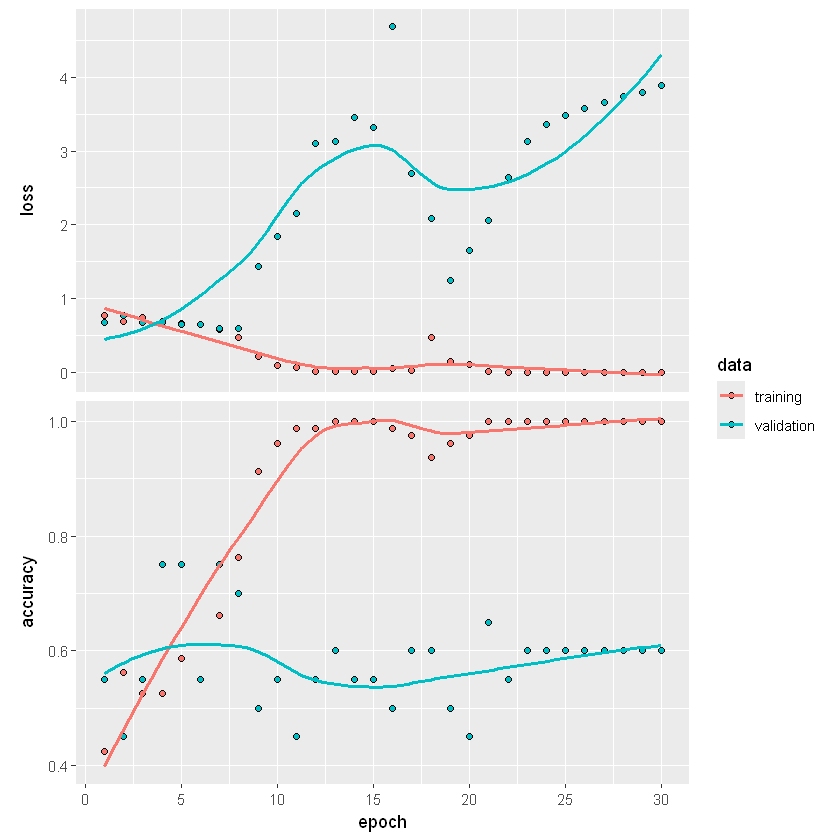

In [149]:
# Linear projection
projected <- input %>%
  layer_dense(units = 128)

# Add positional encoding
pos_enc <- positional_encoding(176, 128)
pos_enc_tensor <- tf$convert_to_tensor(pos_enc, dtype = "float32")
expanded_pos_enc <- tf$expand_dims(pos_enc_tensor, axis = as.integer(0))
tiled_pos_enc <- tf$tile(
  expanded_pos_enc,
  multiples = c(tf$shape(projected)[1], as.integer(1), as.integer(1))
)
x <- projected + tiled_pos_enc

# Transformer block
norm1 <- x %>% layer_layer_normalization()
attn_output <- layer_multi_head_attention(num_heads = 4, key_dim = 64)(
  query = norm1,
  value = norm1,
  key = norm1
)
x <- layer_add(list(attn_output, projected))
x <- x %>%
  layer_layer_normalization() %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dense(units = 128)


# Global average pooling and output
output <- x %>%
  layer_global_average_pooling_1d() %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(0.3) %>%
  layer_dense(units = 2, activation = "softmax")

# Compile model
model <- keras_model(inputs = input, outputs = output)
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = "accuracy"
)

# Train
history <- model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate
model %>% evaluate(X_test, y_test)
plot(history)

### Hyperparameter tuning & Cross Validation - Transformers

   num_heads key_dim ff_dim dropout_rate mean_accuracy
12         8      32    128          0.2         0.675
    loss accuracy 
1.954878 0.550000 


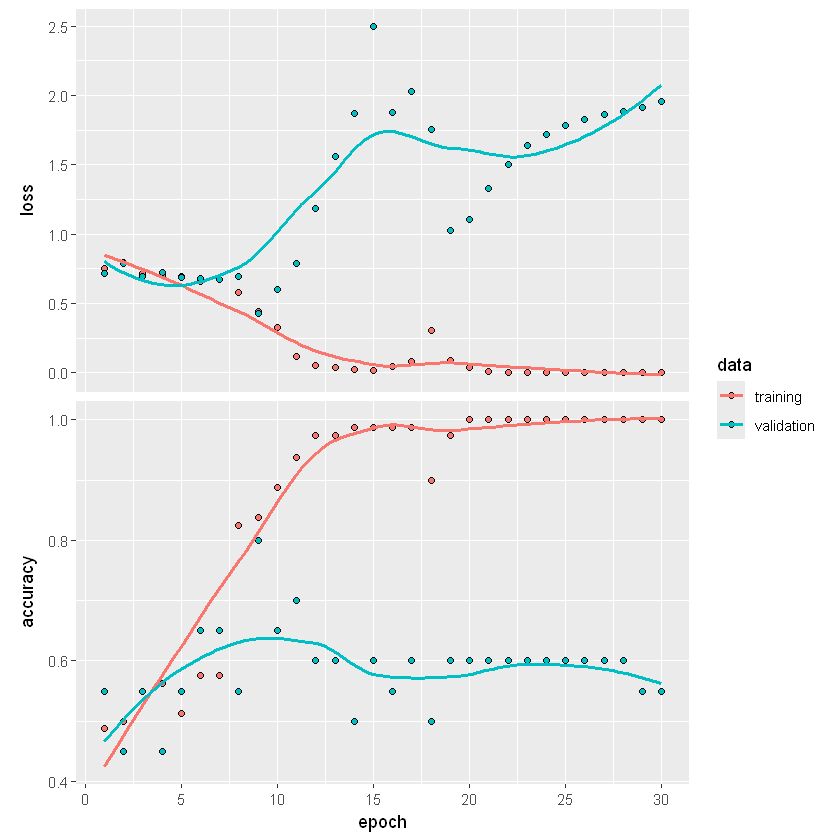

In [ ]:
# Define a function to create Transformer models with hyperparameters
create_transformer_model <- function(
  num_heads = 4,
  key_dim = 64,
  ff_dim = 128,
  dropout_rate = 0.3,
  input_shape = c(176, 110)
) {
  input <- layer_input(shape = input_shape)
  
  # Linear projection
  projected <- input %>%
    layer_dense(units = ff_dim)
  
  # Add positional encoding
  pos_enc <- positional_encoding(input_shape[1], ff_dim)
  pos_enc_tensor <- tf$convert_to_tensor(pos_enc, dtype = "float32")
  expanded_pos_enc <- tf$expand_dims(pos_enc_tensor, axis = as.integer(0))
  tiled_pos_enc <- tf$tile(
    expanded_pos_enc,
    multiples = c(tf$shape(projected)[1], as.integer(1), as.integer(1))
  )
  x <- projected + tiled_pos_enc
  
  # Transformer block
  norm1 <- x %>% layer_layer_normalization()
  attn_output <- layer_multi_head_attention(num_heads = num_heads, key_dim = key_dim)(
    query = norm1,
    value = norm1,
    key = norm1
  )
  x <- layer_add(list(attn_output, projected))
  x <- x %>%
    layer_layer_normalization() %>%
    layer_dense(units = ff_dim, activation = "relu") %>%
    layer_dense(units = ff_dim)
  
  # Global average pooling and output
  output <- x %>%
    layer_global_average_pooling_1d() %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = 2, activation = "softmax")
  
  # Build and compile the model
  model <- keras_model(inputs = input, outputs = output)
  model %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = "accuracy"
  )
  
  return(model)
}

# Define hyperparameter grid
hyper_grid <- expand.grid(
  num_heads = c(2, 4, 8),
  key_dim = c(32, 64, 128),
  ff_dim = c(64, 128, 256),
  dropout_rate = c(0.2, 0.3, 0.4)
)

# Cross-validation setup
k_folds <- 5
cv_results <- data.frame()

# Generate fold indices manually
set.seed(123)
fold_indices <- split(seq_len(dim(X_train)[1]), rep(1:k_folds, length.out = dim(X_train)[1]))

# Perform k-fold cross-validation
for (i in seq_len(nrow(hyper_grid))) {
  params <- hyper_grid[i, ]
  fold_accuracies <- c()
  
  for (fold in seq_len(k_folds)) {
    # Split data into training and validation sets
    val_indices <- fold_indices[[fold]]
    train_indices <- setdiff(seq_len(dim(X_train)[1]), val_indices)
    
    X_train_fold <- X_train[train_indices, , ]
    y_train_fold <- y_train[train_indices, ]
    X_val_fold <- X_train[val_indices, , ]
    y_val_fold <- y_train[val_indices, ]
    
    # Create and train the model
    model <- create_transformer_model(
      num_heads = params$num_heads,
      key_dim = params$key_dim,
      ff_dim = params$ff_dim,
      dropout_rate = params$dropout_rate,
      input_shape = c(176, 110)
    )
    
    history <- model %>% fit(
      X_train_fold, y_train_fold,
      epochs = 10,  # Use fewer epochs for faster tuning
      batch_size = 8,
      validation_data = list(X_val_fold, y_val_fold),
      verbose = 0
    )
    
    # Evaluate on validation set
    eval_result <- model %>% evaluate(X_val_fold, y_val_fold, verbose = 0)
    val_accuracy <- eval_result[[2]]  # Accuracy is the second element
    fold_accuracies <- c(fold_accuracies, val_accuracy)
  }
  
  # Store results
  mean_accuracy <- mean(fold_accuracies)
  cv_results <- rbind(cv_results, cbind(params, mean_accuracy))
}

# Find the best hyperparameters
best_params <- cv_results[which.max(cv_results$mean_accuracy), ]
print(best_params)

# Train the final model with the best hyperparameters
final_model <- create_transformer_model(
  num_heads = best_params$num_heads,
  key_dim = best_params$key_dim,
  ff_dim = best_params$ff_dim,
  dropout_rate = best_params$dropout_rate,
  input_shape = c(176, 110)
)

history <- final_model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate the final model
final_eval <- final_model %>% evaluate(X_test, y_test)
print(final_eval)
summary(final_model)
plot(history)

## Mixed 

### 1D CNN + LSTM Model

The mixed 1D CNN + LSTM model combines the feature extraction capabilities of Convolutional Neural Networks (CNNs) with the temporal dependency modeling of Long Short-Term Memory (LSTM) networks. This hybrid architecture is particularly effective for time-series data, such as fMRI signals, where both spatial and temporal patterns are important.

#### Architecture:
1. **Input Layer**:
   - Input shape: `(timesteps, features)` (e.g., `176 x 110` for 176 time steps and 110 features).

2. **1D CNN Block**:
   - **Conv1D**: 64 filters, kernel size = 3, activation = ReLU.
   - **Max Pooling**: Pool size = 2, reduces spatial dimensions.
   - **Dropout**: Rate = 0.3, prevents overfitting.

3. **LSTM Block**:
   - **LSTM**: 64 units, processes sequential data and captures temporal dependencies.
   - **Dropout**: Rate = 0.3.

4. **Fully Connected Layers**:
   - **Dense**: 64 units, activation = ReLU.
   - **Dropout**: Rate = 0.3.
   - **Dense**: 2 units, activation = Softmax (for binary classification).

#### Compilation:
- **Optimizer**: Adam.
- **Loss Function**: Categorical Crossentropy.
- **Metrics**: Accuracy.

loss  accuracy 
0.9694079 0.7500000

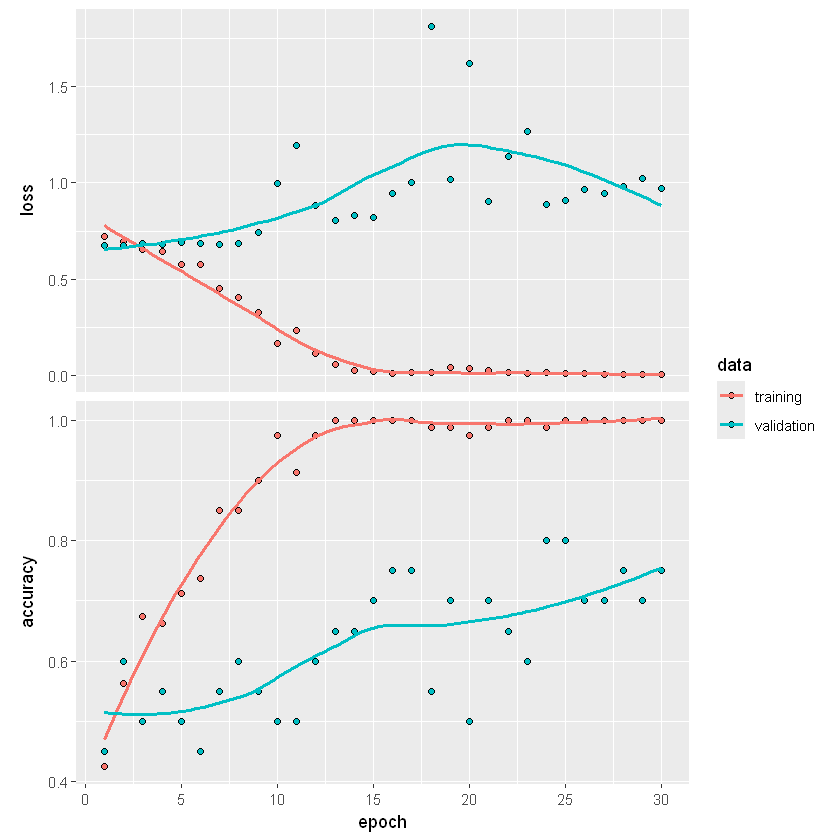

In [178]:
# Input shape: (time steps = 176, features = 110)
input <- layer_input(shape = c(176, 110))

# 1D CNN Block
cnn_out <- input %>%
  layer_conv_1d(filters = 64, kernel_size = 3, activation = "relu") %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(rate = 0.3)

# LSTM Block
lstm_out <- cnn_out %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.3)

# Fully Connected Layers
output <- lstm_out %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 2, activation = "softmax")

# Build model
model <- keras_model(inputs = input, outputs = output)

# Compile
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = "accuracy"
)

# Train
history <- model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate
model %>% evaluate(X_test, y_test)
plot(history)

### Hyperparameter tuning & Cross Validation - Mixed 1D CNN + LSTM model

   filters kernel_size lstm_units dropout_rate mean_accuracy
29      64           5         64          0.3        0.5625
    loss accuracy 
1.032197 0.700000 
Model: "model_2185"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_2204 (InputLayer)            [(None, 176, 110)]              0           
 conv1d_2541 (Conv1D)               (None, 172, 64)                 35264       
 max_pooling1d_2516 (MaxPooling1D)  (None, 86, 64)                  0           
 dropout_5735 (Dropout)             (None, 86, 64)                  0           
 lstm_1254 (LSTM)                   (None, 64)                      33024       
 dropout_5736 (Dropout)             (None, 64)                      0           
 dense_6097 (Dense)                 (None, 64)                      4160        
 dropout_5737 (Dropout)             (None, 64)                      0           
 dense_609

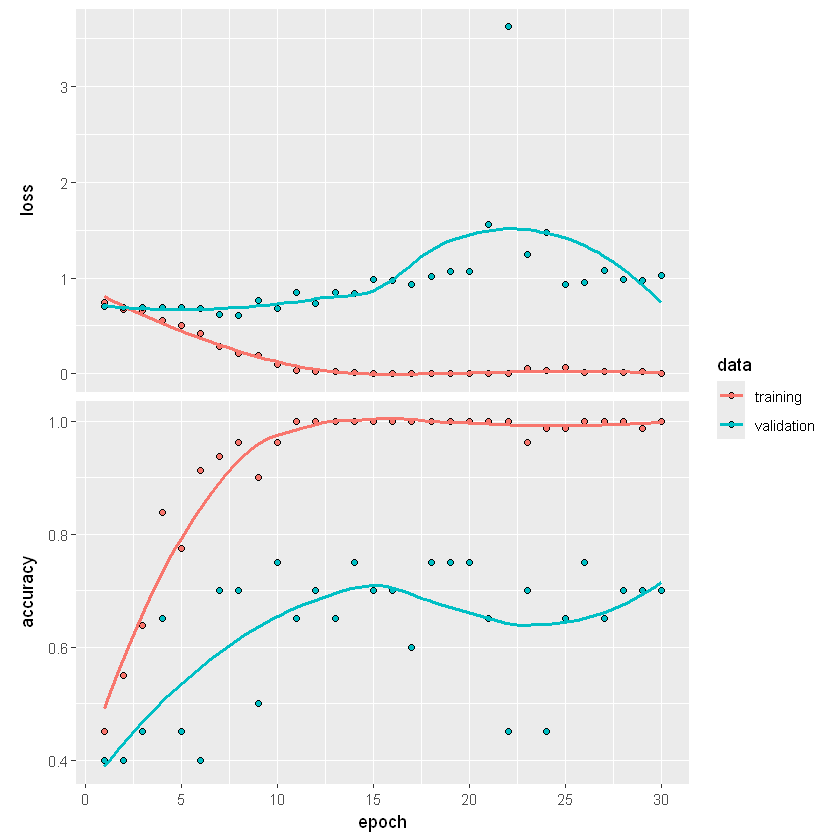

In [210]:
# Hyperparameter tuning and cross-validation for a mixed 1D CNN + LSTM model

# Define a function to create the model with hyperparameters
create_model <- function(filters = 64, kernel_size = 3, lstm_units = 64, dropout_rate = 0.3) {
  input <- layer_input(shape = c(176, 110))
  
  # 1D CNN Block
  cnn_out <- input %>%
    layer_conv_1d(filters = filters, kernel_size = kernel_size, activation = "relu") %>%
    layer_max_pooling_1d(pool_size = 2) %>%
    layer_dropout(rate = dropout_rate)
  
  # LSTM Block
  lstm_out <- cnn_out %>%
    layer_lstm(units = lstm_units, return_sequences = FALSE) %>%
    layer_dropout(rate = dropout_rate)
  
  # Fully Connected Layers
  output <- lstm_out %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = 2, activation = "softmax")
  
  # Build and compile the model
  model <- keras_model(inputs = input, outputs = output)
  model %>% compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = "accuracy"
  )
  
  return(model)
}

# Define hyperparameter grid
hyper_grid <- expand.grid(
  filters = c(32, 64, 128),
  kernel_size = c(3, 5),
  lstm_units = c(32, 64, 128),
  dropout_rate = c(0.2, 0.3, 0.4)
)

# Cross-validation setup
k_folds <- 5
cv_results <- data.frame()

# Generate fold indices manually
set.seed(123)
fold_indices <- split(seq_len(dim(X_train)[1]), rep(1:k_folds, length.out = dim(X_train)[1]))

# Perform k-fold cross-validation
for (i in seq_len(nrow(hyper_grid))) {
  params <- hyper_grid[i, ]
  fold_accuracies <- c()
  
  for (fold in seq_len(k_folds)) {
    # Split data into training and validation sets
    val_indices <- fold_indices[[fold]]
    train_indices <- setdiff(seq_len(dim(X_train)[1]), val_indices)
    
    X_train_fold <- X_train[train_indices, , ]
    y_train_fold <- y_train[train_indices, ]
    X_val_fold <- X_train[val_indices, , ]
    y_val_fold <- y_train[val_indices, ]
    
    # Create and train the model
    model <- create_model(
      filters = params$filters,
      kernel_size = params$kernel_size,
      lstm_units = params$lstm_units,
      dropout_rate = params$dropout_rate
    )
    
    history <- model %>% fit(
      X_train_fold, y_train_fold,
      epochs = 10,  # Use fewer epochs for faster tuning
      batch_size = 8,
      validation_data = list(X_val_fold, y_val_fold),
      verbose = 0
    )
    
    # Evaluate on validation set
    eval_result <- model %>% evaluate(X_val_fold, y_val_fold, verbose = 0)
    val_accuracy <- eval_result[[2]]  # Accuracy is the second element
    fold_accuracies <- c(fold_accuracies, val_accuracy)
  }
  
  # Store results
  mean_accuracy <- mean(fold_accuracies)
  cv_results <- rbind(cv_results, cbind(params, mean_accuracy))
}

# Find the best hyperparameters
best_params <- cv_results[which.max(cv_results$mean_accuracy), ]
print(best_params)

# Train the final model with the best hyperparameters
final_model <- create_model(
  filters = best_params$filters,
  kernel_size = best_params$kernel_size,
  lstm_units = best_params$lstm_units,
  dropout_rate = best_params$dropout_rate
)

history <- final_model %>% fit(
  X_train, y_train,
  epochs = 30,
  batch_size = 8,
  validation_data = list(X_test, y_test)
)

# Evaluate the final model
final_eval <- final_model %>% evaluate(X_test, y_test)
print(final_eval)
summary(final_model)
plot(history)

## GCN - Graph Convolutional Networks

### Spatial-Temporal GCN

The region coordinates are obtained from hoa112 brain atlas.

https://github.com/cwatson/brainGraph/blob/master/data/hoa112.rda

Brain region names are presented as abbreviations in the hoa112 atlas (hoa112$name), the atlas abbreviations and dataset brain region names are matched and coordinates are assigned to each region.

There are no mature GCN libraries in R, therefore the data is saved and used with Python implementation of the ST-GCM with "stgcm.py" file (also available as a jupyter notebook "stgcm.ipynb").

In [28]:
# Get unique region coordinates
coords <- normalized_all_data_long_with_coords %>%
  select(RegionName, x.mni, y.mni, z.mni) %>%
  distinct()

# Create pairwise Euclidean distances
dist_matrix <- as.matrix(dist(coords[, c("x.mni", "y.mni", "z.mni")]))
rownames(dist_matrix) <- coords$RegionName
colnames(dist_matrix) <- coords$RegionName

# Create Gaussian-based adjacency matrix (tunable sigma)
sigma <- mean(dist_matrix)
adj_matrix <- exp(-dist_matrix^2 / (2 * sigma^2))

# Optionally threshold small weights
adj_matrix[adj_matrix < 0.1] <- 0

In [23]:
# Read the HOAextended.csv file
hoa_coords <- read.csv("data/HOAextended.csv", stringsAsFactors = FALSE)

# Check column names to confirm
print(colnames(hoa_coords))

# Merge coordinates into your long-format fMRI data
all_data_long_with_coords <- all_data_long %>%
  left_join(
    hoa_coords %>% select(Brain.Region, x.mni, y.mni, z.mni),
    by = c("RegionName" = "Brain.Region")
  )

# merge coordinates into normalized data
normalized_all_data_long_with_coords <- normalized_all_data_long %>%
  left_join(
    hoa_coords %>% select(Brain.Region, x.mni, y.mni, z.mni),
    by = c("RegionName" = "Brain.Region")
  )

# Now all_data_long_with_coords has columns: Time, RegionName, Signal, Subject, Group, x.mni, y.mni, z.mni
head(normalized_all_data_long_with_coords)

[1] "Label"        "Brain.Region" "name"         "x.mni"        "y.mni"       
[6] "z.mni"        "lobe"         "hemi"         "index"       


Time,RegionName,Signal,Subject,Group,Signal_Z,x.mni,y.mni,z.mni
<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,Left Thalamus,5.468418,ASD_1,ASD,0.31958945,-9.99,-19.16,16.28
0,Left Caudate,-4.865467,ASD_1,ASD,-0.45252176,-12.84,8.92,19.71
0,Left Putamen,-4.636530,ASD_1,ASD,-0.25498105,-24.79,0.54,10.42
0,Left Pallidum,-5.289856,ASD_1,ASD,-0.27990527,-19.13,-5.17,8.53
0,Left Hippocampus,-0.957224,ASD_1,ASD,-0.05714941,-25.18,-23.25,-3.92
0,Left Amygdala,0.185279,ASD_1,ASD,0.01236803,-22.86,-5.18,-7.49


In [ ]:
# Prepare time series array: (subjects, time, regions)
region_names <- sort(unique(normalized_all_data_long_with_coords$RegionName))
subject_ids <- sort(unique(normalized_all_data_long_with_coords$Subject))
n_time <- 176
n_regions <- length(region_names)
n_subjects <- length(subject_ids)

# 3D array: subjects × time × regions
signal_array <- array(NA, dim = c(n_subjects, n_time, n_regions))
label_vector <- numeric(n_subjects)

for (i in seq_along(subject_ids)) {
  subj_data <- normalized_all_data_long_with_coords %>%
    filter(Subject == subject_ids[i]) %>%
    arrange(Time, match(RegionName, region_names))
  
  # Fill signals
  signal_matrix <- matrix(subj_data$Signal, nrow = n_time, byrow = FALSE)
  signal_array[i,,] <- signal_matrix

  # Encode labels: 0 for Normal, 1 for ASD
  label_vector[i] <- ifelse(unique(subj_data$Group) == "ASD", 1, 0)
}

In [27]:
# Save as .RData (optional)
# save(signal_array, label_vector, adj_matrix, region_names, file = "stgcn_data.RData")

# OR save to .npz for Python
library(reticulate)
np <- import("numpy")
np$savez_compressed(
  "stgcn_data.npz",
  signals = signal_array,
  labels = label_vector,
  adj = adj_matrix,
  region_names = region_names
)

In [321]:
# Check for missing coordinates after join
missing_coords <- all_data_long_with_coords %>%
  filter(is.na(x.mni) | is.na(y.mni) | is.na(z.mni))

cat("Rows missing coordinates:", nrow(missing_coords), "\n")
if (nrow(missing_coords) > 0) {
  print(head(missing_coords))
} else {
  cat("All rows have coordinates assigned.\n")
}

Rows missing coordinates: 0 
All rows have coordinates assigned.


In [ ]:
# Get unique lists
subjects <- sort(unique(normalized_all_data_long_with_coords$Subject))
region_names <- sort(unique(normalized_all_data_long_with_coords$RegionName))
num_subjects <- length(subjects)
num_timepoints <- max(normalized_all_data_long_with_coords$Time)
num_regions <- length(region_names)

# Initialize array: [subjects, time, regions]
node_features <- array(NA, dim = c(num_subjects, num_timepoints, num_regions))

for (i in seq_along(subjects)) {
  subj_data <- normalized_all_data_long_with_coords %>%
    filter(Subject == subjects[i]) %>%
    select(Time, RegionName, Signal_Z) %>% # Use Signal_Z for normalized data
    pivot_wider(names_from = RegionName, values_from = Signal_Z) %>%
    arrange(Time) %>%
    select(all_of(region_names))
  mat <- as.matrix(subj_data)
  # Pad if needed
  if (nrow(mat) < num_timepoints) {
    pad <- matrix(0, nrow = num_timepoints - nrow(mat), ncol = num_regions)
    mat <- rbind(mat, pad)
  }
  node_features[i, , ] <- mat[1:num_timepoints, ]
}

# Prepare adjacency matrix from coordinates (regions x regions)
coords <- normalized_all_data_long_with_coords %>%
  select(RegionName, x.mni, y.mni, z.mni) %>%
  distinct(RegionName, .keep_all = TRUE) %>%
  arrange(RegionName)
coord_mat <- as.matrix(coords[, c("x.mni", "y.mni", "z.mni")])
dist_mat <- as.matrix(dist(coord_mat))
adjacency <- ifelse(dist_mat < 20, 1, 0) # threshold in mm
diag(adjacency) <- 0

# Prepare labels (0 = ASD, 1 = Normal)
labels <- ifelse(grepl("^ASD", subjects), 0, 1)

# Save for Python
np <- import("numpy")
np$save("node_features.npy", node_features)
np$save("adjacency.npy", adjacency)
np$save("labels.npy", as.integer(labels))

In [ ]:
source_python("stgcn.py")

py_run_file("stgcn.py")